In [1]:
import pandas as pd
import Bio
from Bio import SeqIO
from Bio.Alphabet import generic_dna
from Bio.Seq import Seq
import pickle
from collections import Counter
import timeit
import copy
###
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import igraph
import seaborn
###import packages
from scEasyMode import mousefilter
from scEasyMode import clusterplot
from scEasyMode import pymulti
from scEasyMode import sceasy
###
sc.set_figure_params(dpi=120,vector_friendly=False,format='pdf')

## readin data

In [2]:
###readin
osi= sceasy.read('../osi_only.preprocessed')

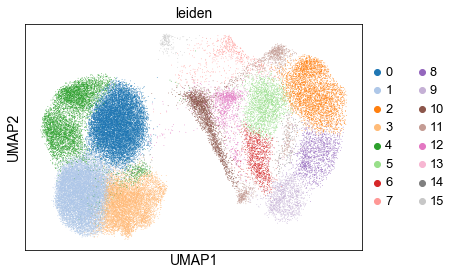

In [3]:
sc.pl.umap(osi,color='leiden',save='leiden.pdf')

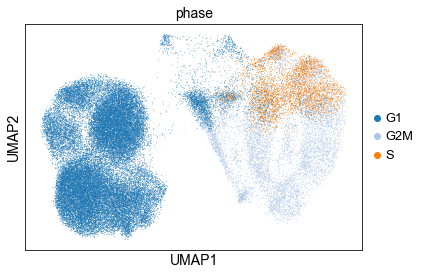

In [4]:
sc.pl.umap(osi,color='phase',save='phase.pdf')

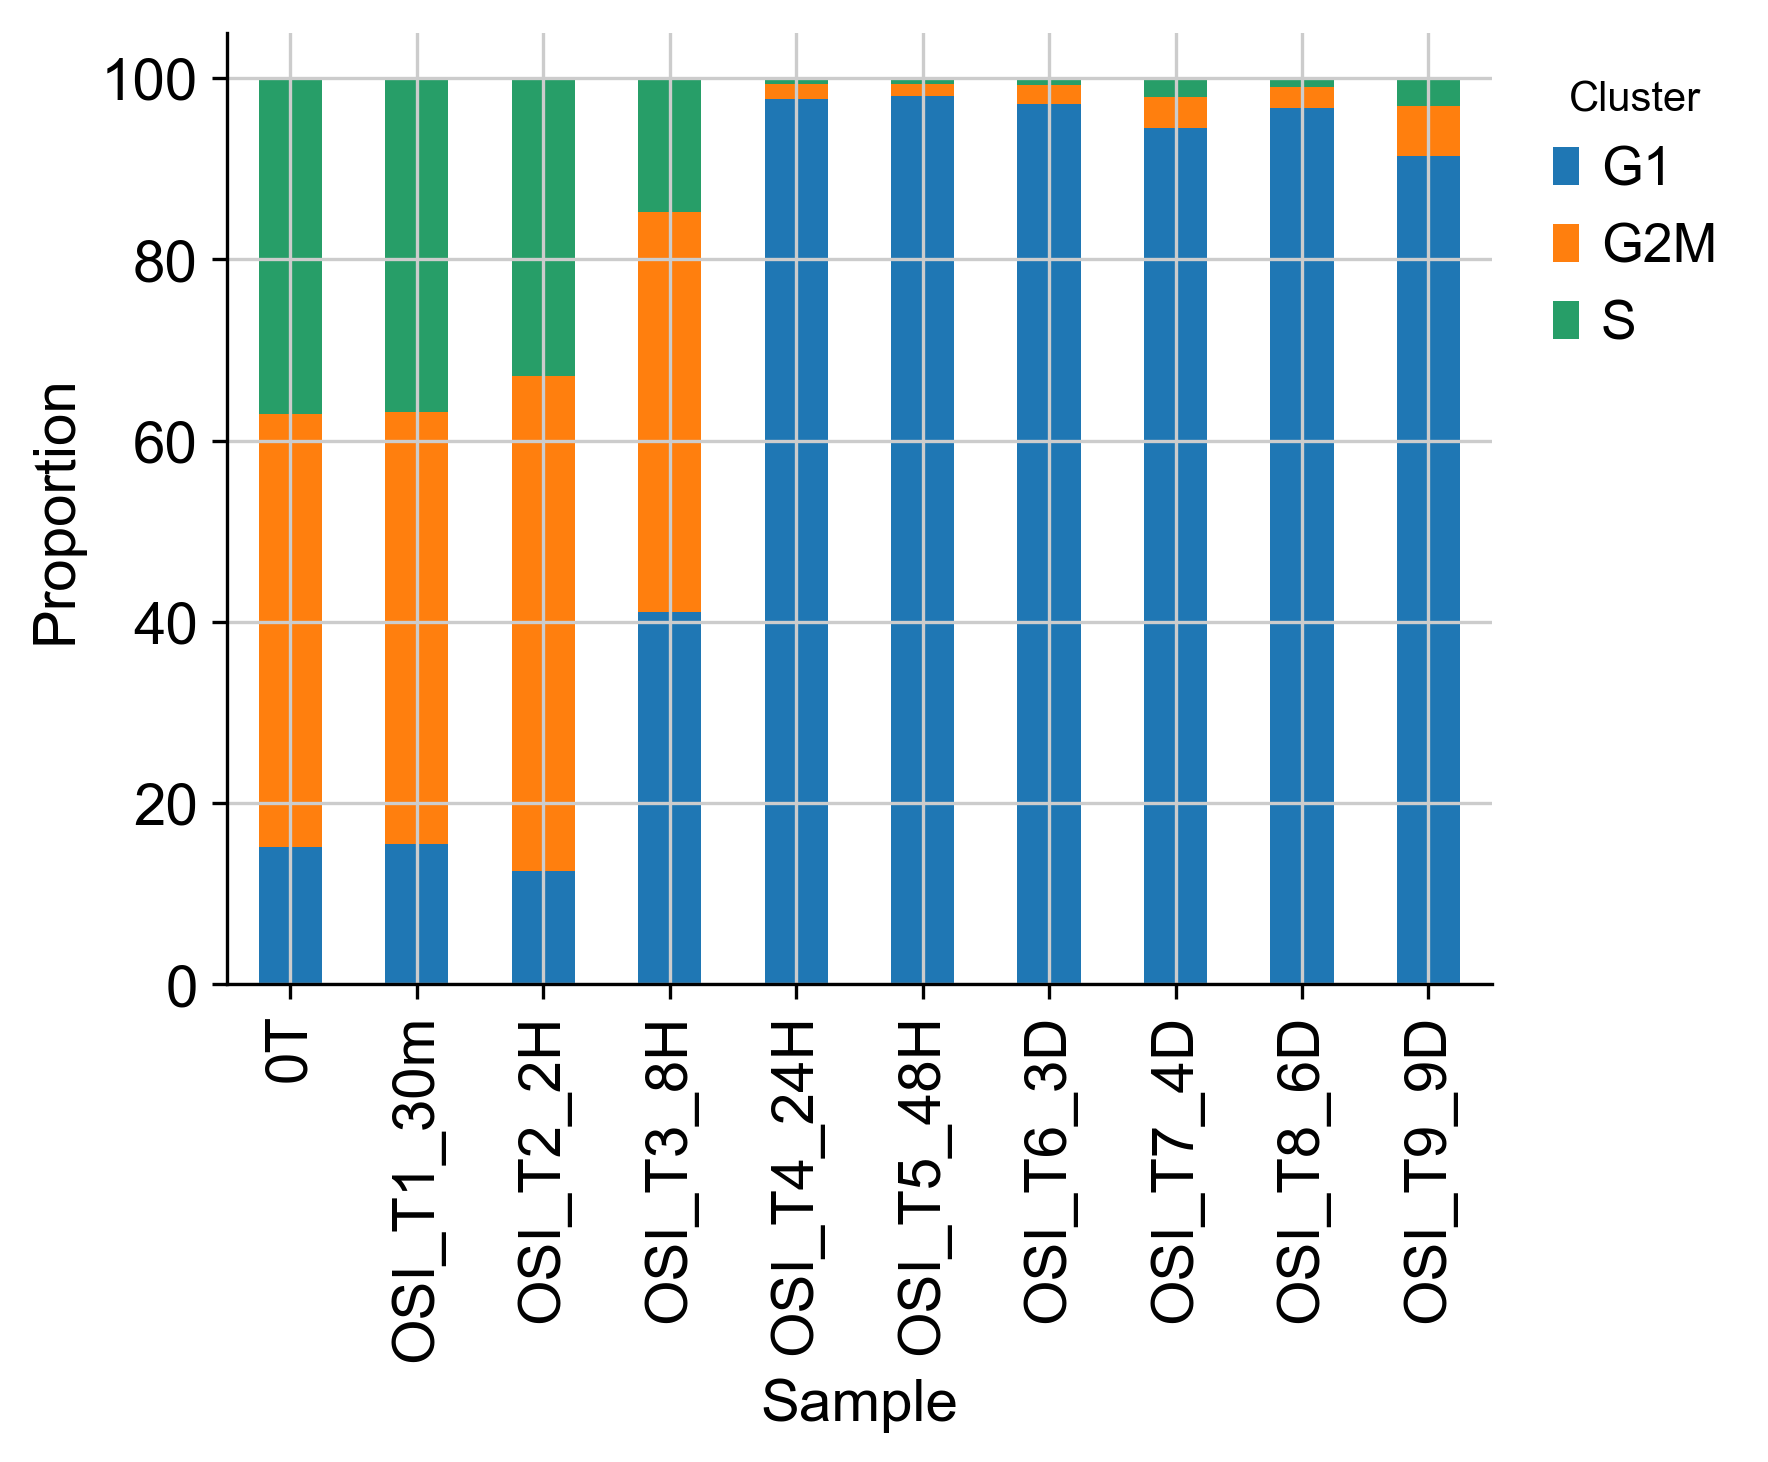

In [5]:
clusterplot.plot(osi,covariates=['phase'],sample='sample')
plt.xticks(rotation=90)
plt.savefig('figures/phase.stacked.pdf')

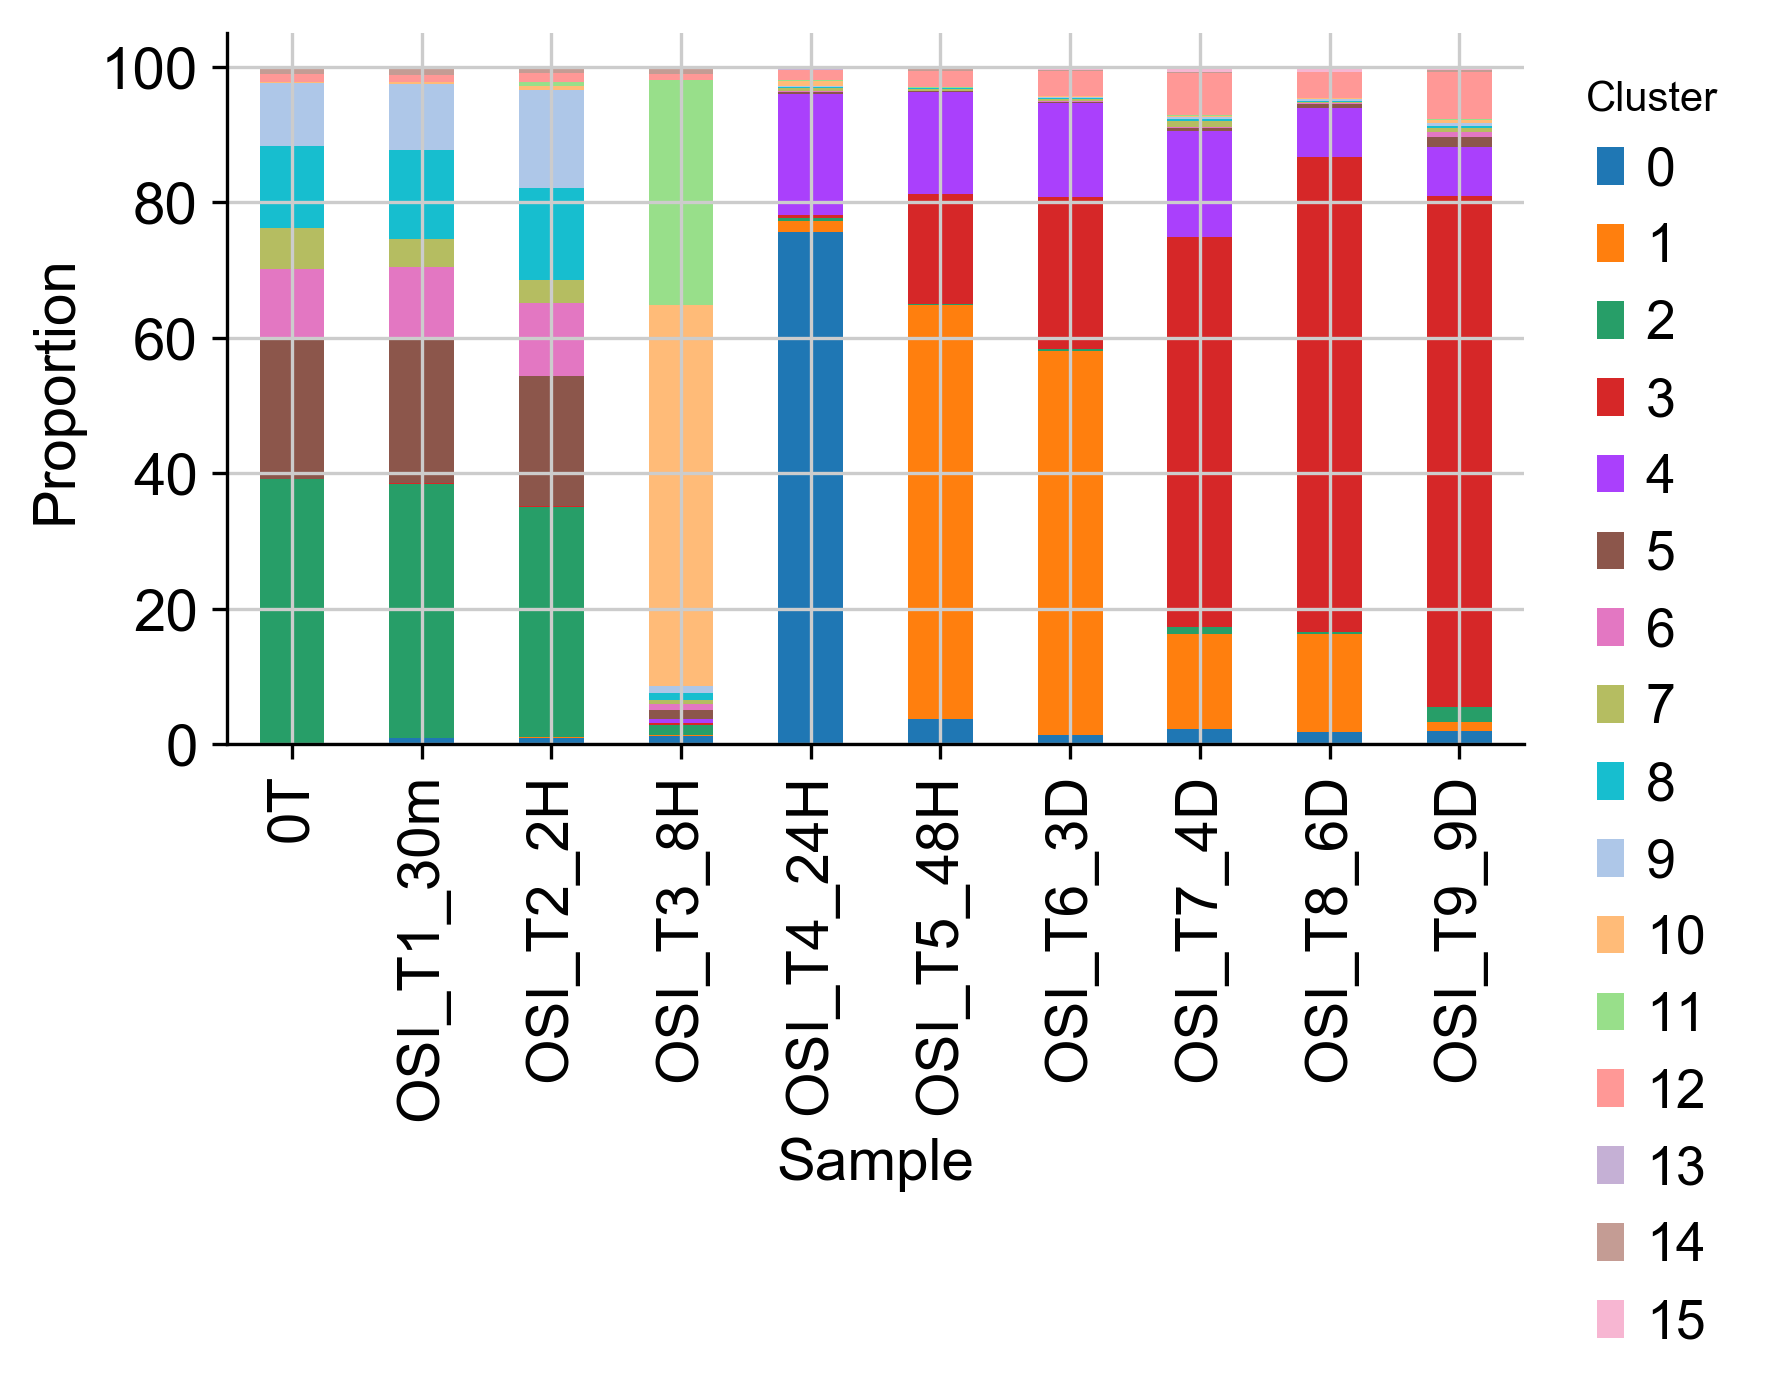

In [6]:
clusterplot.plot(osi,covariates=['leiden'],sample='sample')
plt.xticks(rotation=90)
plt.savefig('figures/leiden.stacked.pdf')

## overlay gbcs into scdata

In [7]:
###define functions for splitting gbcs into the scdata
def if_batch(dicts,row):
    tmp_dict = dicts[int(row.batch)]
    ###
    if row.barcode in tmp_dict.keys():
        return(tmp_dict[row.barcode])
    else:
        return('NA')
    
def overlay_gbcs(adata,calls,sigs,label1='sig_gbc',label2='call_gbc'):
    ###write into .obs
    adata.obs[label1] = adata.obs.apply(lambda row: if_batch(calls,row),axis=1)
    adata.obs[label2] = adata.obs.apply(lambda row: if_batch(sigs,row),axis=1)
    ###return
    return(adata)

In [9]:
###read in the scdata
gbcs = ['097','098','099',100,101,102,103,104]
calls = []
sigs = []
###
for gbc in gbcs:
    gbc_df = pd.read_csv('../pymulti/GBCs_'+str(gbc)+'_calls.tsv',sep='\t',index_col=0)[['call','sig']]
    ###convert to dictionary
    mdict1 = gbc_df.to_dict()[gbc_df.columns[0]]
    mdict2 = gbc_df.to_dict()[gbc_df.columns[1]]
    ###append by batch #
    calls.append(mdict1)
    sigs.append(mdict2)

In [10]:
###overlay the osi gbcs 
osi = overlay_gbcs(osi,calls,sigs)

Trying to set attribute `.obs` of view, making a copy.


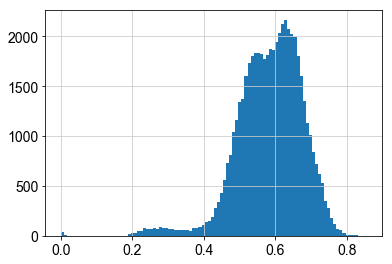

In [11]:
###subset and filter
osi = osi[osi.obs['sig_gbc']!='NA']
osi.obs.call_gbc = osi.obs.call_gbc.astype('float32')
osi.obs.sig_gbc = osi.obs.sig_gbc.astype('str')
osi.obs['call_gbc'].hist(bins=100)
osi = osi[osi.obs.call_gbc>=0.45]

In [12]:
osi.shape

(50204, 14296)

Trying to set attribute `.obs` of view, making a copy.
... storing 'sig_gbc' as categorical


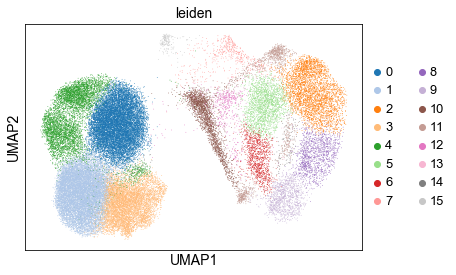

In [13]:
sc.pl.umap(osi,color='leiden')

In [14]:
### change things over into continuous time
sample_dict = {
    '0T':0,
    'OSI_T1_30m':0.5,
    'OSI_T2_2H':2,
    'OSI_T3_8H':8,
    'OSI_T4_24H':24,
    'OSI_T5_48H':48,
    'OSI_T6_3D':72,
    'OSI_T7_4D':96,
    'OSI_T8_6D':144,
    'OSI_T9_9D':216,
}
###
osi.obs['time'] = osi.obs.apply(lambda row: sample_dict[row['sample']],axis=1) 

### see distributions of gbcs across time in bulk 

In [18]:
merged = pd.read_csv('../bulk.merged.gbcs.csv',sep=',',index_col=0)
###
t_0 = merged.transpose()['t_0']
t_0 = t_0.dropna()
### define whitelist
whitelist = t_0.index.tolist()

In [348]:
def normalize_1(row):
    ### normalizes the proportions to one
    return(row/row.sum())

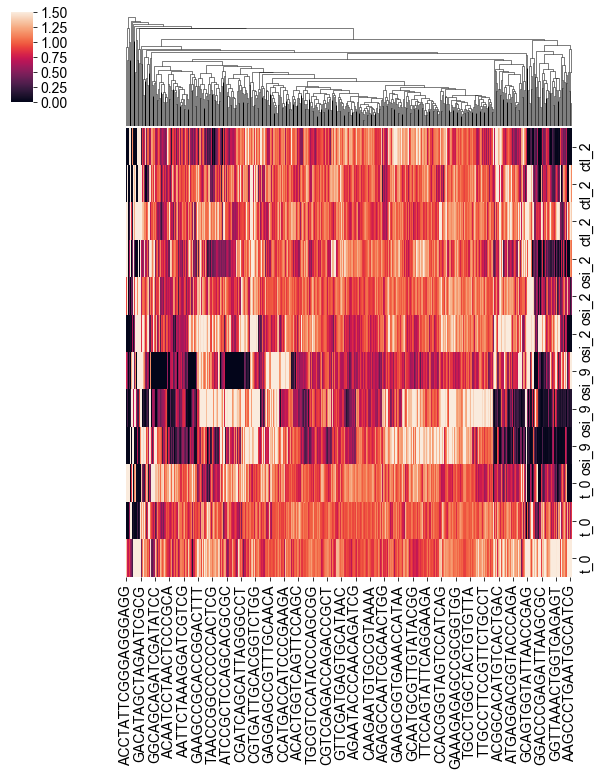

In [353]:
### divide by T0 , scale to 1
test = merged[whitelist]
test = test.replace(to_replace=np.nan,value=0)
### sum to 1 for each sample
test = test.apply(normalize_1,axis=1)
### divide by t0
test = test/test.loc['t_0'].mean()
### a lot outliers, scale
test[test>1.5] = 1.5
seaborn.clustermap(test,vmin=0,row_cluster=False)

## lets log2 transform these since they are not normal

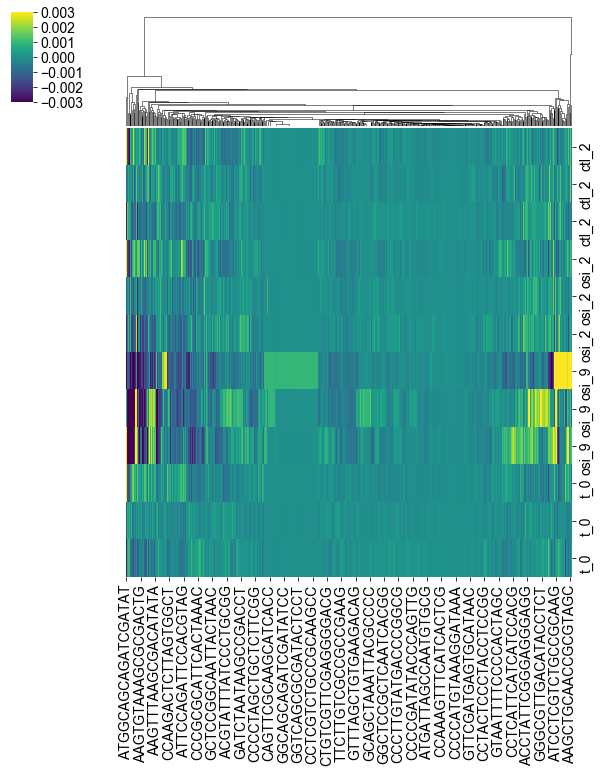

In [354]:
### replace zeros
test = merged[whitelist]
test = test.replace(to_replace=np.nan,value=0.001)
### sum to 1 for each sample
test = test.apply(normalize_1,axis=1)
### log10 transform
test.apply(np.log10)
test = test-test.loc['t_0'].mean()
### plot
seaborn.clustermap(test,vmin=-0.003,vmax=0.003,row_cluster=False,cmap='viridis')

## lets zscore this by sample

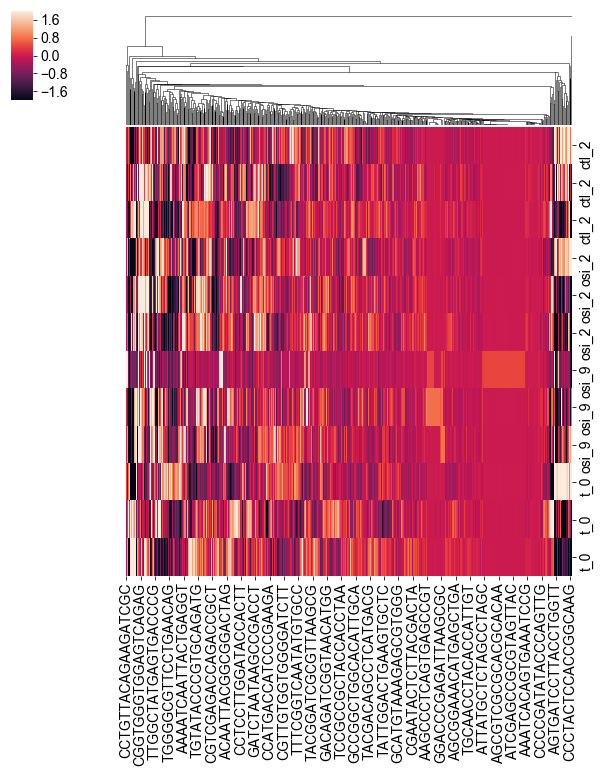

In [355]:
from scipy.stats import zscore
### zscore within sample
test = merged[whitelist]
test = test.replace(to_replace=np.nan,value=0.001)
### sum to 1 for each sample
test = test.apply(normalize_1,axis=1)
### log10 transform
test.apply(np.log10)
test = test-test.loc['t_0'].mean()
###
test = test.transpose()
zscored = pd.DataFrame(test.apply(zscore))
zscored = zscored.transpose()
### plot
seaborn.clustermap(zscored,row_cluster=False,vmin=-2,vmax=2)

## zscore by barcode

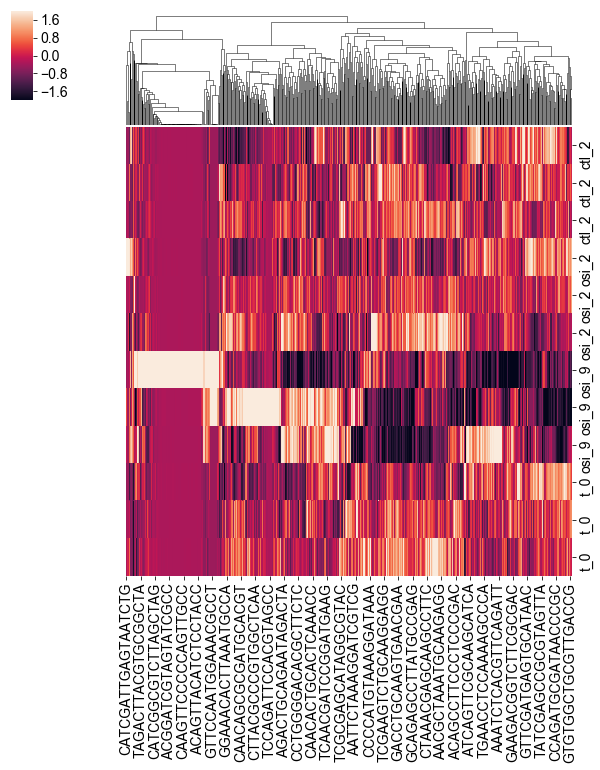

In [356]:
from scipy.stats import zscore
### zscore within sample
test = merged[whitelist]
test = test.replace(to_replace=np.nan,value=0.001)
### sum to 1 for each sample
test = test.apply(normalize_1,axis=1)
### log10 transform
test.apply(np.log10)
test = test-test.loc['t_0'].mean()
###
zscored = pd.DataFrame(test.apply(zscore))
### plot
seaborn.clustermap(zscored,row_cluster=False,vmin=-2,vmax=2)

## try rank

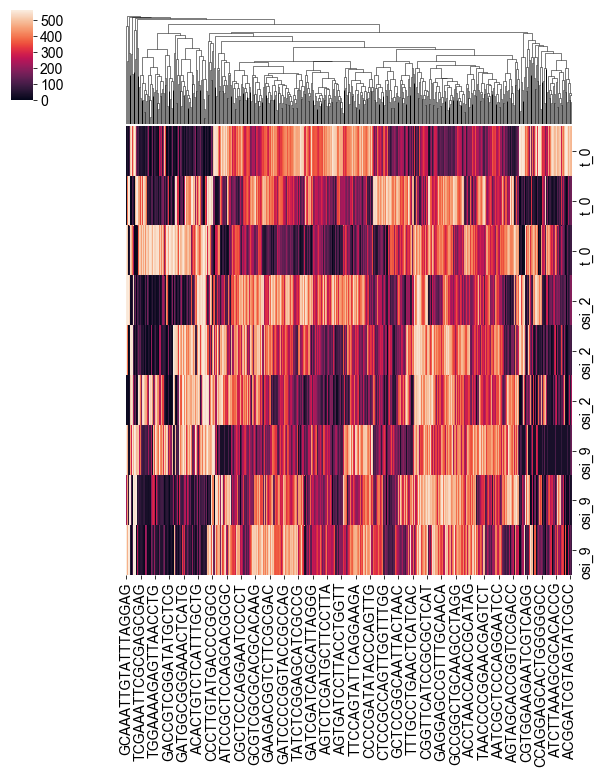

In [357]:
from scipy.stats import zscore
### zscore within sample
test = merged[whitelist]
test = test.replace(to_replace=np.nan,value=0)
### sum to 1 for each sample
test = test.apply(normalize_1,axis=1)
### scale to T0
test = test/test.loc['t_0'].mean()
### rank
test = test.rank(axis=1)
### subset for t0, t2 osi, t9 osi only
test = test.loc[['t_0','osi_2','osi_9']]
###
seaborn.clustermap(test,row_cluster=False)

## okay samples are quite different, need to use replicates to filter out stochastic noise

In [445]:
### formatting
test = merged[whitelist]
test = test.replace(to_replace=np.nan,value=0)
### sum to 1 for each sample
test = test.apply(normalize_1,axis=1)

In [446]:
### test 
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
###
test = test.transpose()
wilcoxon_results = []
test.apply(lambda row: wilcoxon_results.append(ttest_rel(a=row['t_0'],b=row['osi_9'])),axis=1)

AAAATCAATTACTGAGGT    None
AAACCGAAACGAGACATG    None
AAACGATGCATATGAGTG    None
AAAGGAACGGTTCATGTC    None
AAAGGACATGGTCCTATA    None
                      ... 
TTTCGGTCAATATGTGCC    None
TTTGCACCCTGAGCCGGG    None
TTTGCCTGAACTCATCAC    None
TTTGGGGCACGCAGATTG    None
TTTTACGTGTCACACGTA    None
Length: 561, dtype: object

Text(0.5, 1.0, 'distribution of pvalues by ttest')

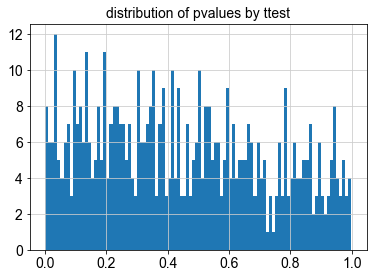

In [447]:
pvals = []
for result in wilcoxon_results:
    pvals.append(result[1])
plt.hist(pvals,bins=100)
plt.title('distribution of pvalues by ttest')

### implement cutoff for pvals

In [448]:
bcs = test.index.tolist()
##
cutoff = 0.12
sig = []
##
for val,bc in zip(pvals,bcs):
    if val <= cutoff:
        sig.append(bc)

## log10 view


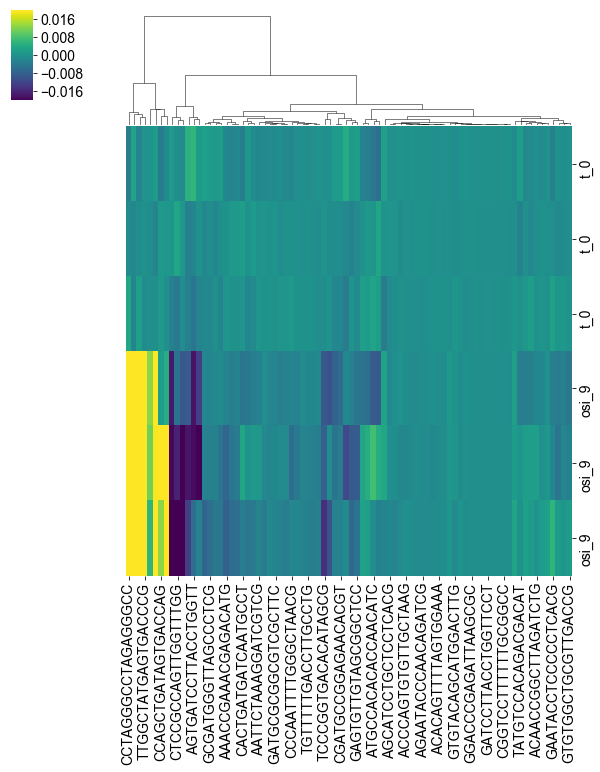

In [450]:
### replace zeros
test = merged[sig]
test = test.replace(to_replace=np.nan,value=0)
### sum to 1 for each sample
test = test.apply(normalize_1,axis=1)
### log10 transform
test.apply(np.log10)
test = test-test.loc['t_0'].mean()
### just get T0 and T9 values
test = test.loc[['t_0','osi_9']]
### plot
seaborn.clustermap(test,vmin=-0.02,vmax=0.02,row_cluster=False,cmap='viridis',metric='euclidean',method='ward')

## lets zscore this by sample

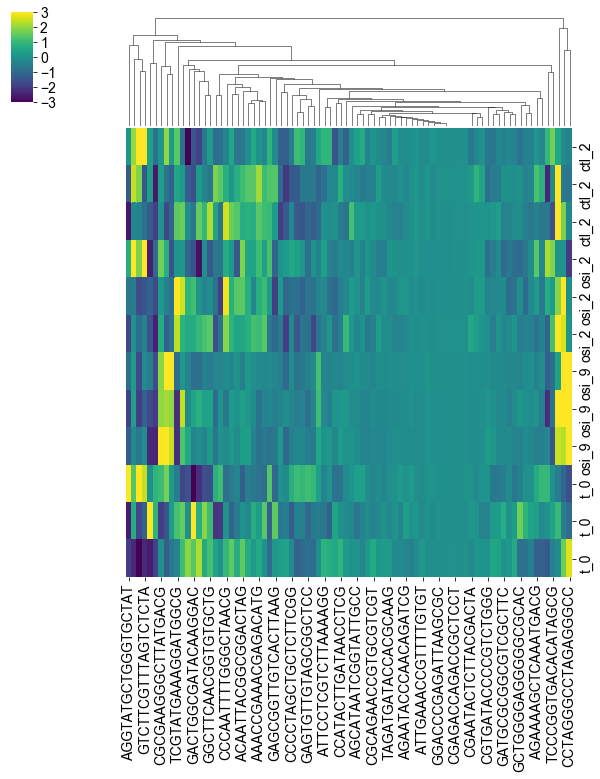

In [453]:
from scipy.stats import zscore
### zscore within sample
test = merged[sig]
test = test.replace(to_replace=np.nan,value=0.0)
### sum to 1 for each sample
test = test.apply(normalize_1,axis=1)
### log10 transform
test.apply(np.log10)
test = test-test.loc['t_0'].mean()
###
test = test.transpose()
zscored = pd.DataFrame(test.apply(zscore))
zscored = zscored.transpose()
### plot
seaborn.clustermap(zscored,row_cluster=False,vmin=-3,vmax=3,cmap='viridis')

## zscore by barcode

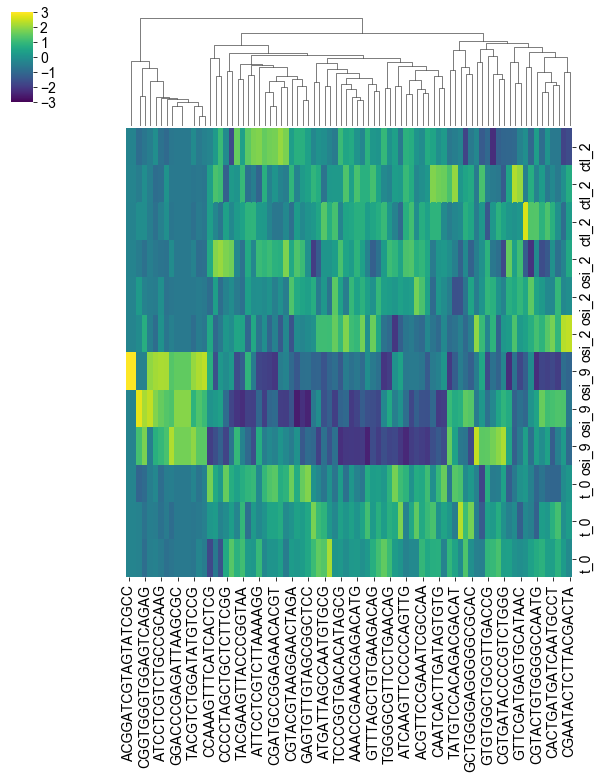

In [454]:
from scipy.stats import zscore
### zscore within sample
test = merged[sig]
test = test.replace(to_replace=np.nan,value=0.001)
### sum to 1 for each sample
test = test.apply(normalize_1,axis=1)
### log10 transform
test.apply(np.log10)
test = test-test.loc['t_0'].mean()
###
zscored = pd.DataFrame(test.apply(zscore))
### plot
seaborn.clustermap(zscored,row_cluster=False,vmin=-3,vmax=3,cmap='viridis')

## try rank

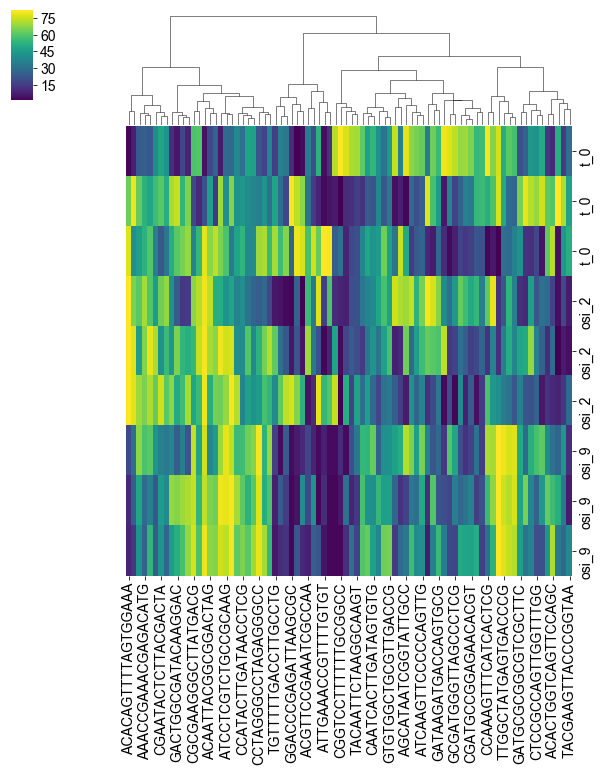

In [457]:
from scipy.stats import zscore
### zscore within sample
test = merged[sig]
test = test.replace(to_replace=np.nan,value=0)
### sum to 1 for each sample
test = test.apply(normalize_1,axis=1)
### scale to T0
test = test/test.loc['t_0'].mean()
### rank
test = test.rank(axis=1)
### subset for t0, t2 osi, t9 osi only
test = test.loc[['t_0','osi_2','osi_9']]
###
seaborn.clustermap(test,row_cluster=False,cmap='viridis',metric='euclidean',method='ward')

## the best visualization is the log10 ratio, after subsetting for non-stochastic changes. Proceed to define clusters

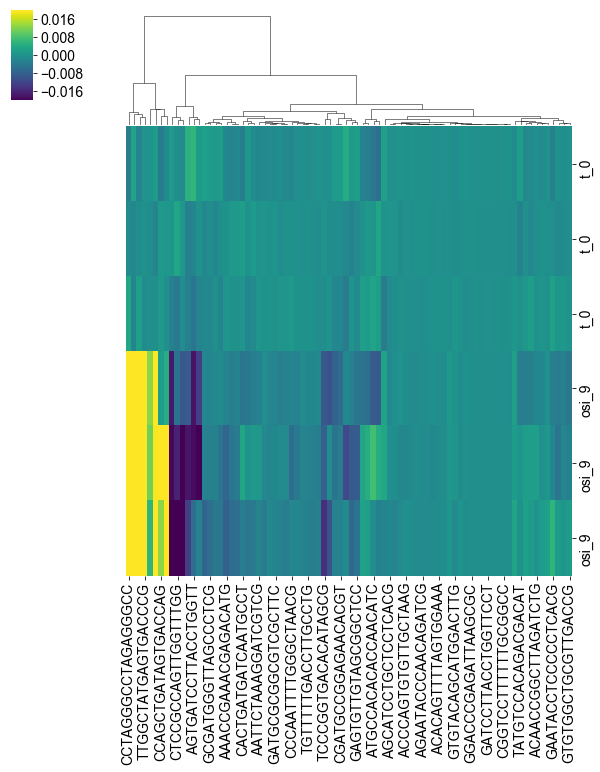

In [489]:
### replace zeros
test = merged[sig]
test = test.replace(to_replace=np.nan,value=0.0)
### sum to 1 for each sample
test = test.apply(normalize_1,axis=1)
### log10 transform
test.apply(np.log10)
test = test-test.loc['t_0'].mean()
### just get T0 and T9 values
test = test.loc[['t_0','osi_9']]
### plot
seaborn.clustermap(test,vmin=-0.02,vmax=0.02,row_cluster=False,cmap='viridis',metric='euclidean',method='ward')
### save 
plt.savefig('figures/sig_clusters_short.pdf')

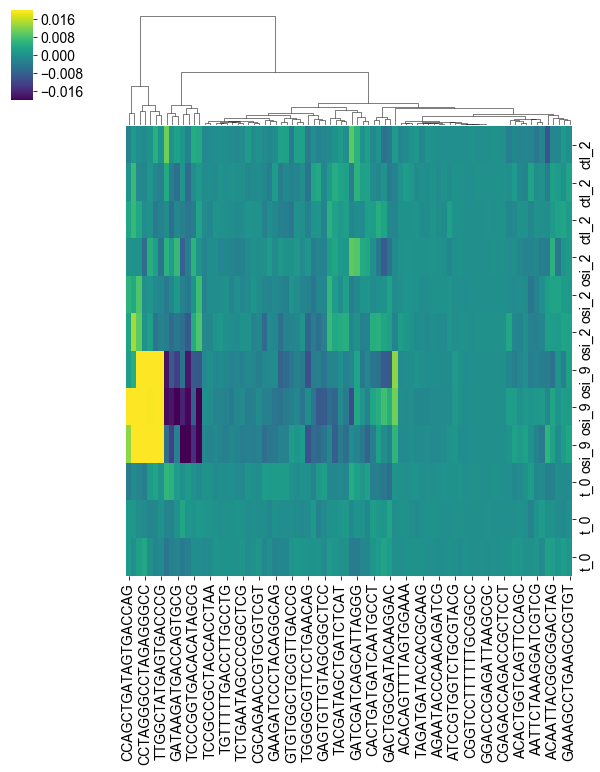

In [497]:
### replace zeros
test = merged[sig]
test = test.replace(to_replace=np.nan,value=0.0)
### sum to 1 for each sample
test = test.apply(normalize_1,axis=1)
### log10 transform
test.apply(np.log10)
test = test-test.loc['t_0'].mean()
### plot
seaborn.clustermap(test,vmin=-0.02,vmax=0.02,row_cluster=False,cmap='viridis',metric='euclidean',method='ward')
### save 
plt.savefig('figures/sig_clusters.pdf')

In [499]:
def densitymap(adata,sample_key='sample',save=None):
    """ Plots the density of samples across umap space 
        adata = anndata object to act on
        key = the key on which to split the dataset and visualize samples individually.
        
        Returns a plot to the interpreter.
    """ 
    sc.tl.embedding_density(adata, basis='umap', groupby=sample_key)
    sc.pl.embedding_density(adata, basis='umap', key='umap_density_'+sample_key,save=save)

Trying to set attribute `.obs` of view, making a copy.
... storing 'time' as categorical


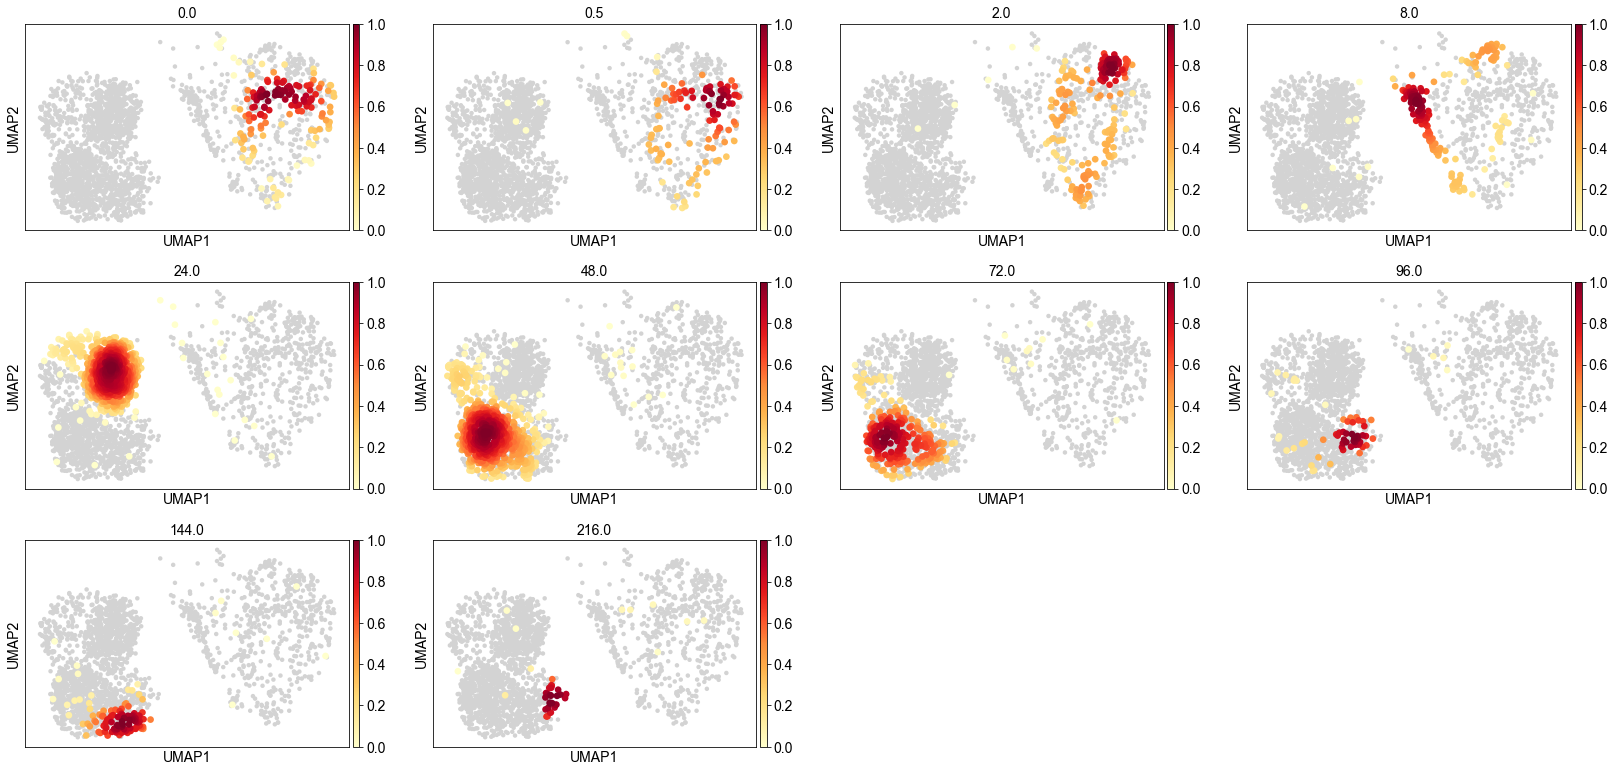

Trying to set attribute `.obs` of view, making a copy.
... storing 'time' as categorical


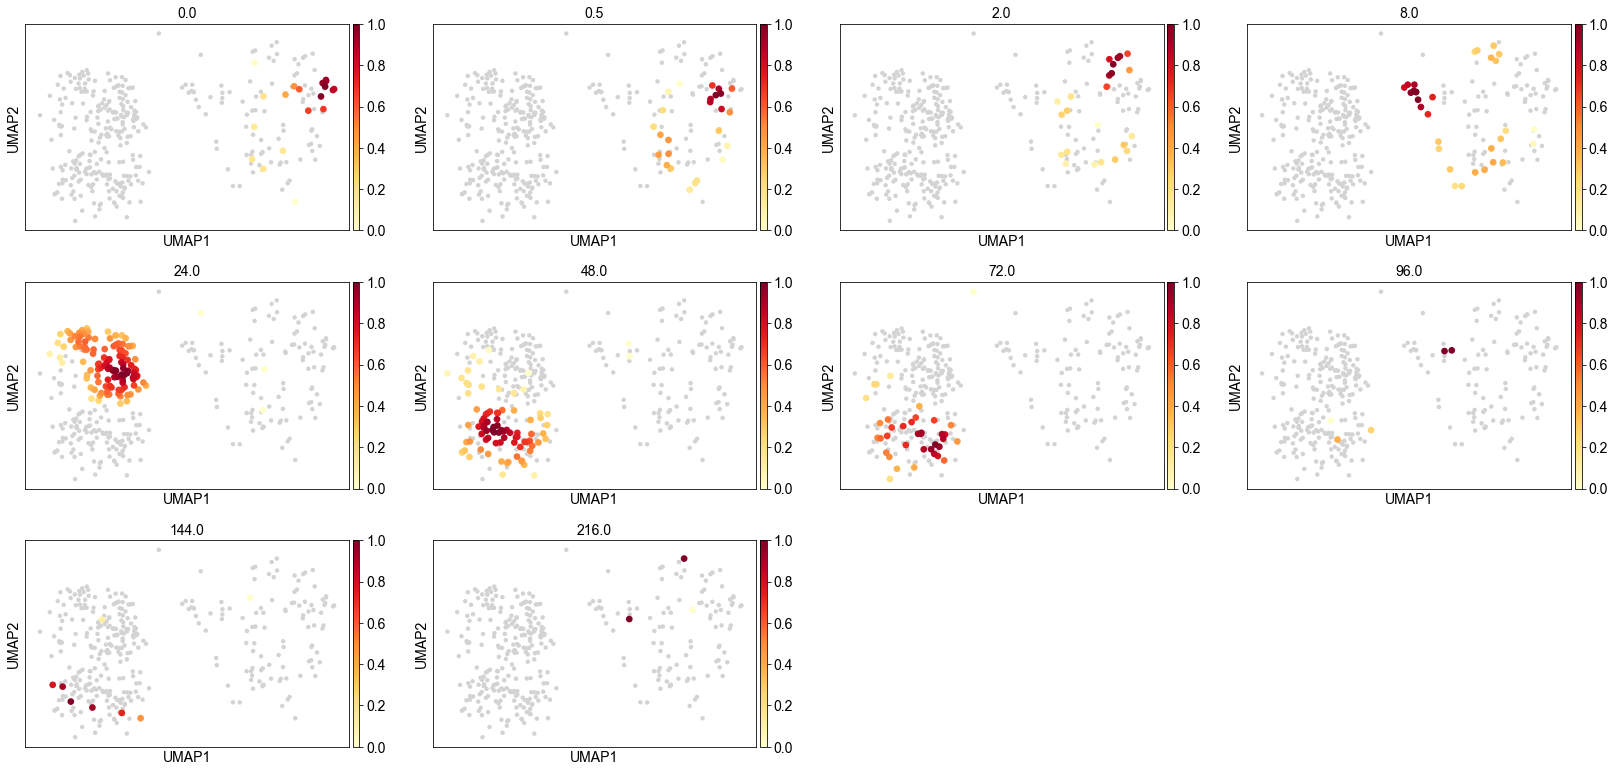

Trying to set attribute `.obs` of view, making a copy.
... storing 'time' as categorical


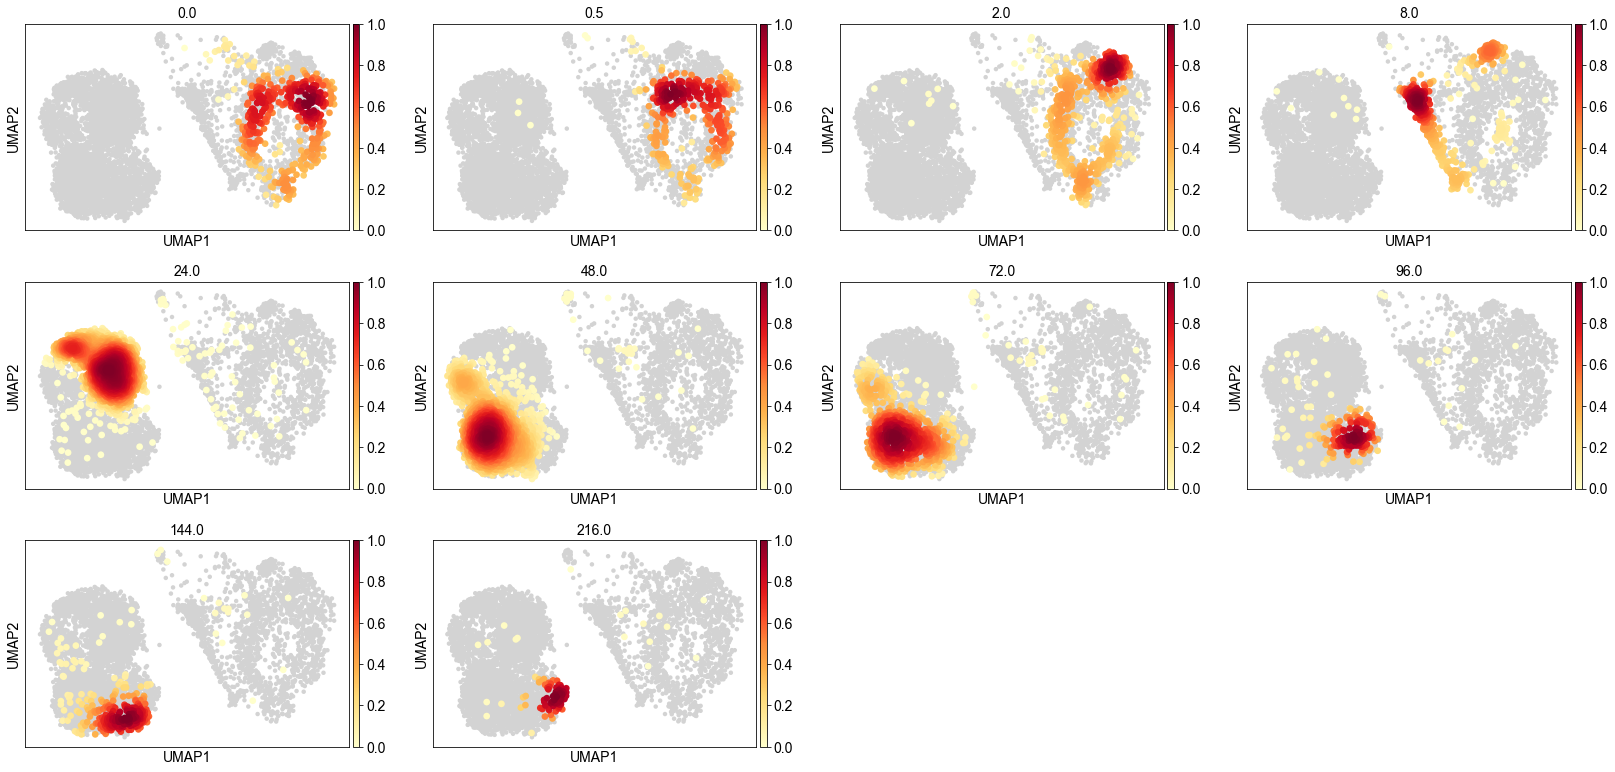

In [500]:
import scipy.cluster.hierarchy as sch
####
numclusts = 3
rngclusts = range(1,numclusts+1)
####
df = test.transpose().copy()
# retrieve clusters using fcluster 
d = sch.distance.pdist(df,metric='euclidean')
L = sch.linkage(d, method='ward')
# t can be modified to retrieve more stringent or relaxed clusters
clusters = sch.fcluster(L, t=numclusts, criterion='maxclust')
# clusters indicices correspond to incides of original df
clustering = []
# subset clusters
sets = []
sets_sc = []
###
for i,cluster in enumerate(clusters):
    clustering.append([df.index[i], cluster])
###
clustering = pd.DataFrame(clustering)
clustering.columns = ['barcode','cluster']
for clust in rngclusts:
    tmpset = clustering[clustering['cluster']==clust]
    tmpset = tmpset.barcode.tolist()
    ##
    sets.append(tmpset)
    ##
    sets_sc.append(osi[osi.obs.sig_gbc.isin(tmpset)])
###
i=0
for set_sc in sets_sc:
    set_sc.obs.time = set_sc.obs.time.astype('str')
    densitymap(set_sc,sample_key='time')
    i+=1

In [480]:
# sets=[]
# ###
# clustering = pd.DataFrame(clustering)
# clustering.columns = ['barcode','cluster']
# for clust in rngclusts:
#     tmpset = clustering[clustering['cluster']==clust]
#     tmpset = tmpset.barcode.tolist()
#     ##
#     sets.append(tmpset)

## the overall visualization is not informative. the differences between time points are greater than the differences between lineages.

#### keep in mind we have to take the stochastic ones that were excluded before so we have 3 clusters:
##### up, down, and nochange

In [517]:
set_up = sets[0]
set_dn = sets[1]
### get stochastic ones
tmp_set = set(set_up).union(set(set_dn))
set_na = []
for bc in whitelist:
    if bc not in tmp_set:
        set_na.append(bc)
### 
set_na = set(set_na)

In [519]:
# ### replace zeros
# test = merged[set_na]
# test = test.replace(to_replace=np.nan,value=0.0)
# ### log10 transform
# test.apply(np.log10)
# test = test-test.loc['t_0'].mean()
# ### plot
# seaborn.clustermap(test,row_cluster=False,cmap='viridis',metric='euclidean',method='ward')
# ### save 

## see change over time in bulk

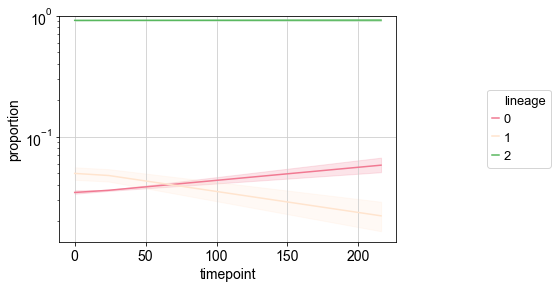

In [625]:
### save lineages
set_lineages = [set_up,set_dn,set_na]
### create lineage dict
dct_lineages = {}
##
i = 0
for lineage in set_lineages:
    for bc in lineage:
        dct_lineages[bc] = i
    i+=1
### slice out only osi from merged
merged_osi = merged.loc[['t_0','osi_2','osi_9']]
### keep only whitelist
merged_osi = merged_osi[whitelist]
### replace nans with zero
merged_osi = merged_osi.replace(to_replace=np.nan,value=0.0)
### sum to 1 for each sample
merged_osi = merged_osi.apply(normalize_1,axis=1)
### stack for plotting
props = merged_osi.transpose()
### add lineage info
props['lineage'] = props.apply(lambda row: dct_lineages[row.name],axis=1)
props = props.groupby(by='lineage').sum()
## format
props = props.stack().reset_index()
props.columns = ['lineage','timepoint','proportion']
### replace times
props = props.replace(to_replace='t_0',value=0.0)
props = props.replace(to_replace='osi_2',value=24.0)
props = props.replace(to_replace='osi_9',value=216.0)
### plot
col_dict = {
    0:'#F17992',
    1:'#FFE4CE',
    2:'#59B85F'
}
seaborn.lineplot(data=props,x='timepoint',y='proportion',hue='lineage',palette=col_dict)
plt.yscale('log')
plt.ylim(0,1.0)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.savefig('figures/totalcells.timepoint.lineages.osi.pdf')

## visualize relative change in bulk; to T0

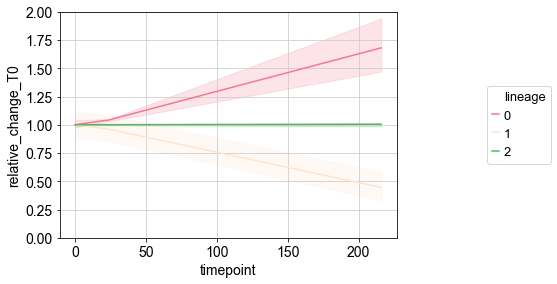

In [626]:
### save lineages
set_lineages = [set_up,set_dn,set_na]
### create lineage dict
dct_lineages = {}
##
i = 0
for lineage in set_lineages:
    for bc in lineage:
        dct_lineages[bc] = i
    i+=1
### slice out only osi from merged
merged_osi = merged.loc[['t_0','osi_2','osi_9']]
### keep only whitelist
merged_osi = merged_osi[whitelist]
### replace nans with zero
merged_osi = merged_osi.replace(to_replace=np.nan,value=0.0)
### sum to 1 for each sample
merged_osi = merged_osi.apply(normalize_1,axis=1)
### stack for plotting
props = merged_osi.transpose()
### add lineage info
props['lineage'] = props.apply(lambda row: dct_lineages[row.name],axis=1)
props = props.groupby(by='lineage').sum()
### divide by t_0 mean
props = props.transpose()/props['t_0'].transpose().mean().tolist()
props = props.transpose()
## format
props = props.stack().reset_index()
props.columns = ['lineage','timepoint','relative_change_T0']
### replace times
props = props.replace(to_replace='t_0',value=0.0)
props = props.replace(to_replace='osi_2',value=24.0)
props = props.replace(to_replace='osi_9',value=216.0)
### plot
col_dict = {
    0:'#F17992',
    1:'#FFE4CE',
    2:'#59B85F'
}
seaborn.lineplot(data=props,x='timepoint',y='relative_change_T0',hue='lineage',palette=col_dict)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.ylim(0.0,2.0)
plt.savefig('figures/totalcells.timepoint.lineages.relative.osi.pdf')

## visualize in vehicle

### bulk

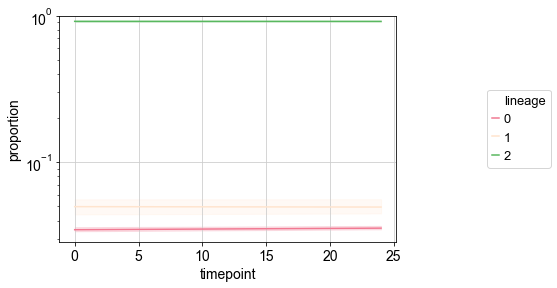

In [627]:
### slice out only osi from merged
merged_osi = merged.loc[['t_0','ctl_2']]
### keep only whitelist
merged_osi = merged_osi[whitelist]
### replace nans with zero
merged_osi = merged_osi.replace(to_replace=np.nan,value=0.0)
### sum to 1 for each sample
merged_osi = merged_osi.apply(normalize_1,axis=1)
### stack for plotting
props = merged_osi.transpose()
### add lineage info
props['lineage'] = props.apply(lambda row: dct_lineages[row.name],axis=1)
props = props.groupby(by='lineage').sum()
## format
props = props.stack().reset_index()
props.columns = ['lineage','timepoint','proportion']
### replace times
props = props.replace(to_replace='t_0',value=0.0)
props = props.replace(to_replace='ctl_2',value=24.0)
### plot
col_dict = {
    0:'#F17992',
    1:'#FFE4CE',
    2:'#59B85F'
}
seaborn.lineplot(data=props,x='timepoint',y='proportion',hue='lineage',palette=col_dict)
plt.yscale('log')
plt.ylim(0,1.0)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.savefig('figures/totalcells.timepoint.lineages.veh.pdf')

### relative

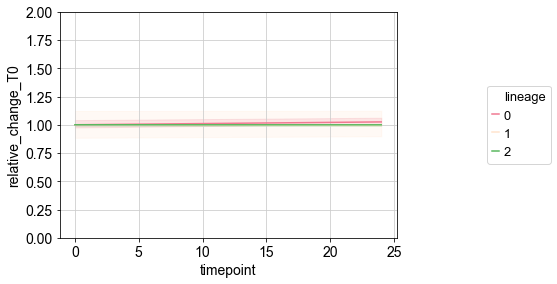

In [628]:
### sum to 1 for each sample
merged_nrm = merged.apply(normalize_1,axis=1)
### slice out only osi from merged
merged_osi = merged_nrm.loc[['t_0','ctl_2']]
### keep only whitelist
merged_osi = merged_osi[whitelist]
### replace nans with zero
merged_osi = merged_osi.replace(to_replace=np.nan,value=0.0)
### stack for plotting
props = merged_osi.transpose()
### add lineage info
props['lineage'] = props.apply(lambda row: dct_lineages[row.name],axis=1)
props = props.groupby(by='lineage').sum()
### divide by t_0 mean
props = props.transpose()/props['t_0'].transpose().mean().tolist()
props = props.transpose()
## format
props = props.stack().reset_index()
props.columns = ['lineage','timepoint','relative_change_T0']
### replace times
props = props.replace(to_replace='t_0',value=0.0)
props = props.replace(to_replace='ctl_2',value=24.0)
### plot
col_dict = {
    0:'#F17992',
    1:'#FFE4CE',
    2:'#59B85F'
}
seaborn.lineplot(data=props,x='timepoint',y='relative_change_T0',hue='lineage',palette=col_dict)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.ylim(0.0,2.0)
plt.savefig('figures/totalcells.timepoint.lineages.relative.veh.pdf')

## now proceed to find diffexp genes in these lineages

#### look at the refined yap genes to see if there is a difference in the expression between clusters, since we know this is a YAP focused project

In [607]:
sets_sc = []
for tmpset in set_lineages:
    sets_sc.append(osi[osi.obs.sig_gbc.isin(tmpset)])

In [659]:
### load genesets
yap = pd.read_csv('../figures/clustering_expr.csv',index_col=0)
yap_set = yap.index.tolist()
clustering_dict = yap['cluster'].to_dict()

In [666]:
sets_metacells = []
sets_metacells_expr = []
##
for tmp_osi in sets_sc:
    ### get metacells, zscore (for plotting) and expr for downstream analysis
    metacells = sceasy.metacell_bylabel(tmp_osi,label='time',zscore=True).transpose()
    metacells_expr = sceasy.metacell_bylabel(tmp_osi,label='time',zscore=False).transpose()
    ### 
    metacells.columns = metacells.columns.astype(str)
    metacells_expr.columns = metacells_expr.columns.astype(str)
    ### format
    metacells = metacells[['0.0','0.5','2.0','8.0','24.0','48.0','72.0','96.0','144.0','216.0']]
    metacells_expr = metacells_expr[['0.0','0.5','2.0','8.0','24.0','48.0','72.0','96.0','144.0','216.0']]
    ### get only yap genes
    metacells = metacells.loc[yap_set]
    metacells_expr = metacells_expr.loc[yap_set]
    ### add in cluster labels
    metacells['cluster'] = metacells.apply(lambda row: clustering_dict[row.name],axis=1)
    metacells_expr['cluster'] = metacells_expr.apply(lambda row: clustering_dict[row.name],axis=1)
    ### save
    sets_metacells.append(metacells)
    sets_metacells_expr.append(metacells_expr)

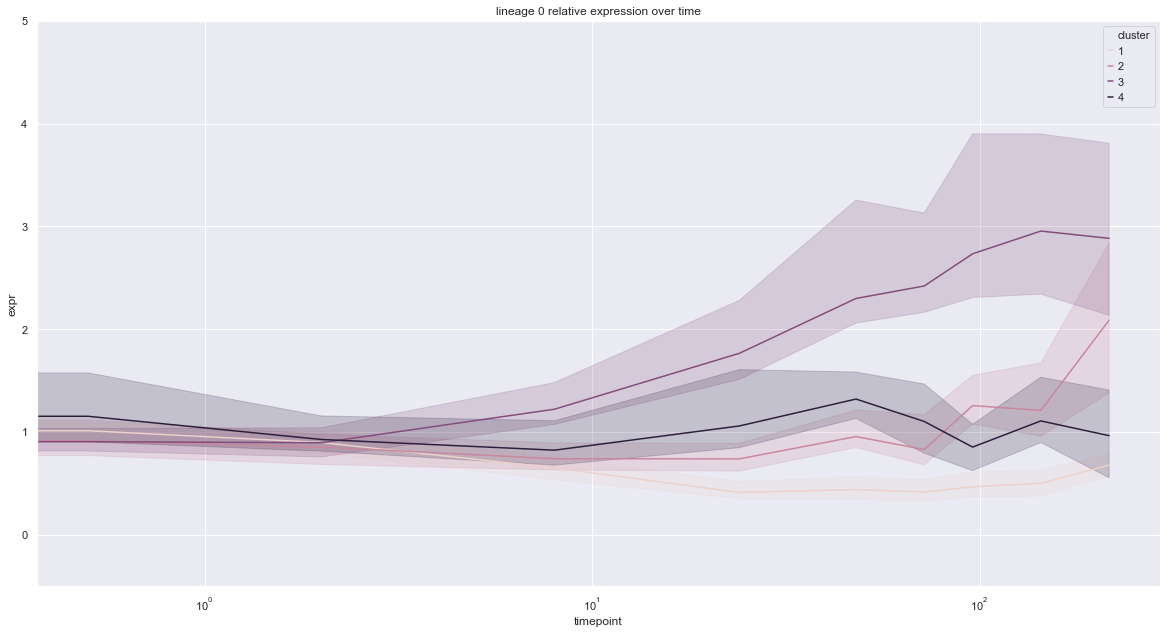

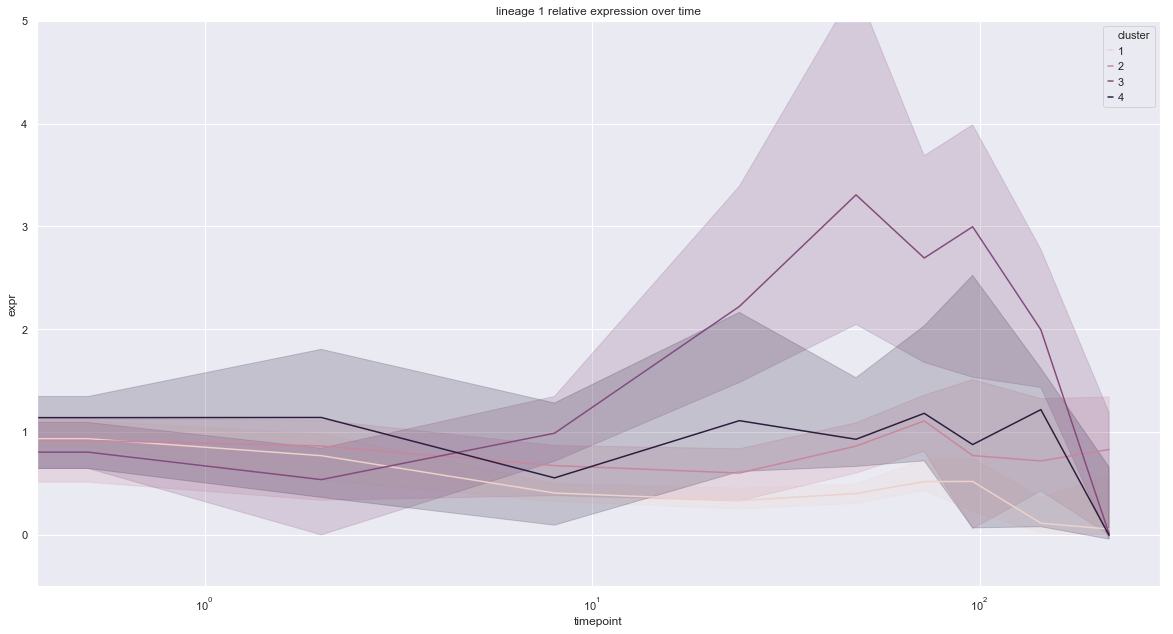

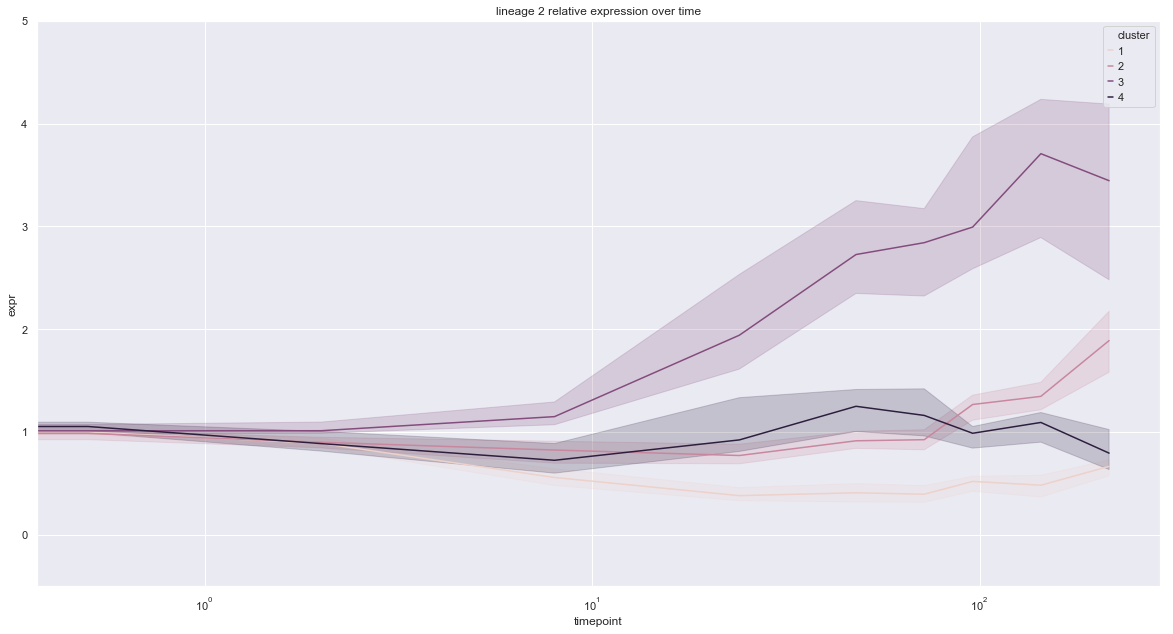

In [672]:
i = 0
###### PLOTTING
for metacells_expr in sets_metacells_expr:
    #### gene expression over time by cluster; expr values
    expr_mean_clust = metacells_expr.copy()
    expr_mean_clust = expr_mean_clust.set_index('cluster')
    ## normalize to T0 
    expr_mean_clust = expr_mean_clust.div(expr_mean_clust['0.0'],axis=0)
    expr_mean_clust
    ## stack
    expr_mean_clust = pd.DataFrame(expr_mean_clust.stack()).reset_index()
    expr_mean_clust.columns = ['cluster','timepoint','expr']
    expr_mean_clust['timepoint'] = expr_mean_clust['timepoint'].astype(np.float)
    ### lineplot
    seaborn.set(rc={'figure.figsize':(20,10)})
    plt.figure()
    #### plot
    grid = seaborn.lineplot(data=expr_mean_clust,x='timepoint',y='expr',hue='cluster',estimator=np.median)
    grid.set(xscale="log")
    plt.ylim(-0.5,5.0)
    plt.title('lineage '+str(i)+' relative expression over time')
    ### save
    plt.savefig('figures/YAP_subset_bytime.lineage_'+str(i)+'.pdf')
    i+=1

## also look at absolute expression over time

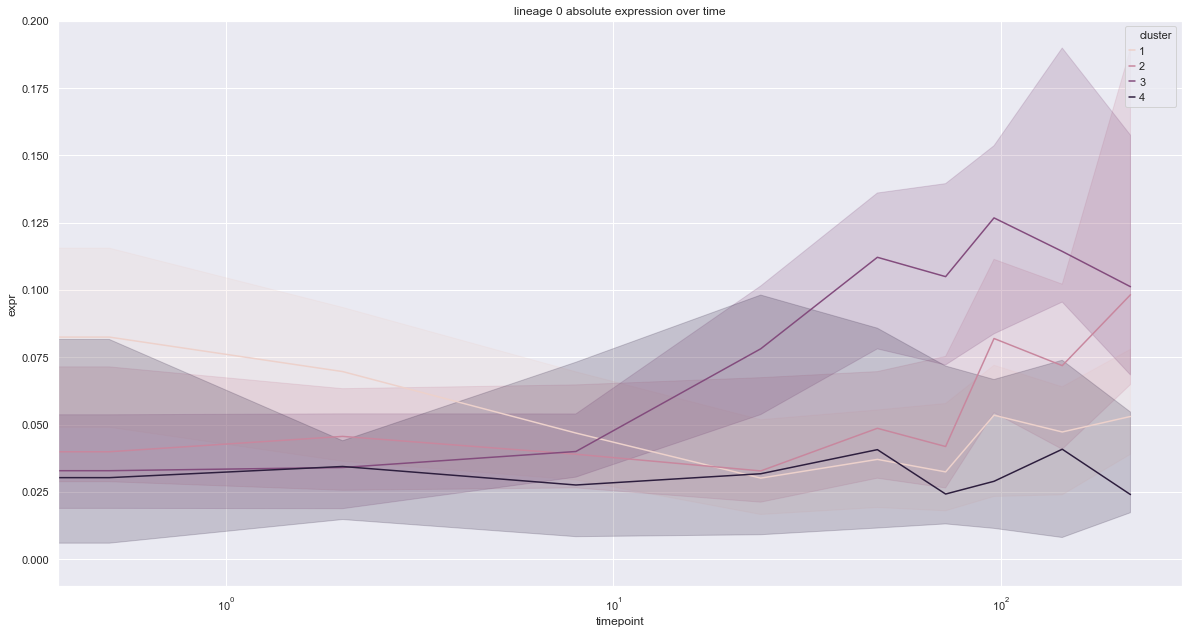

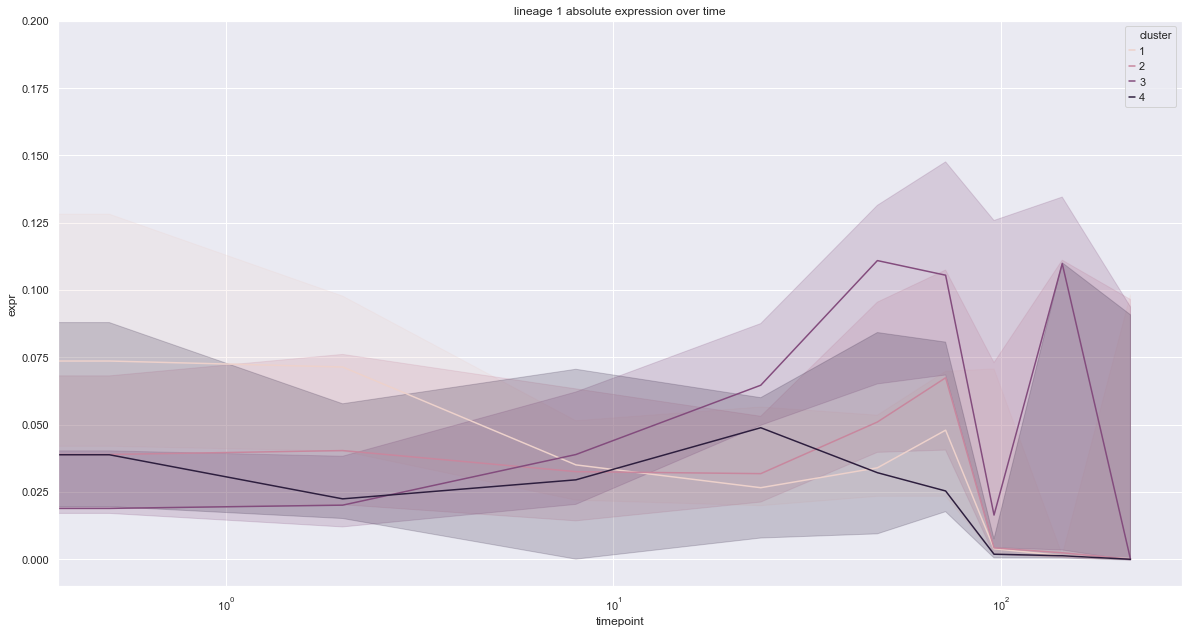

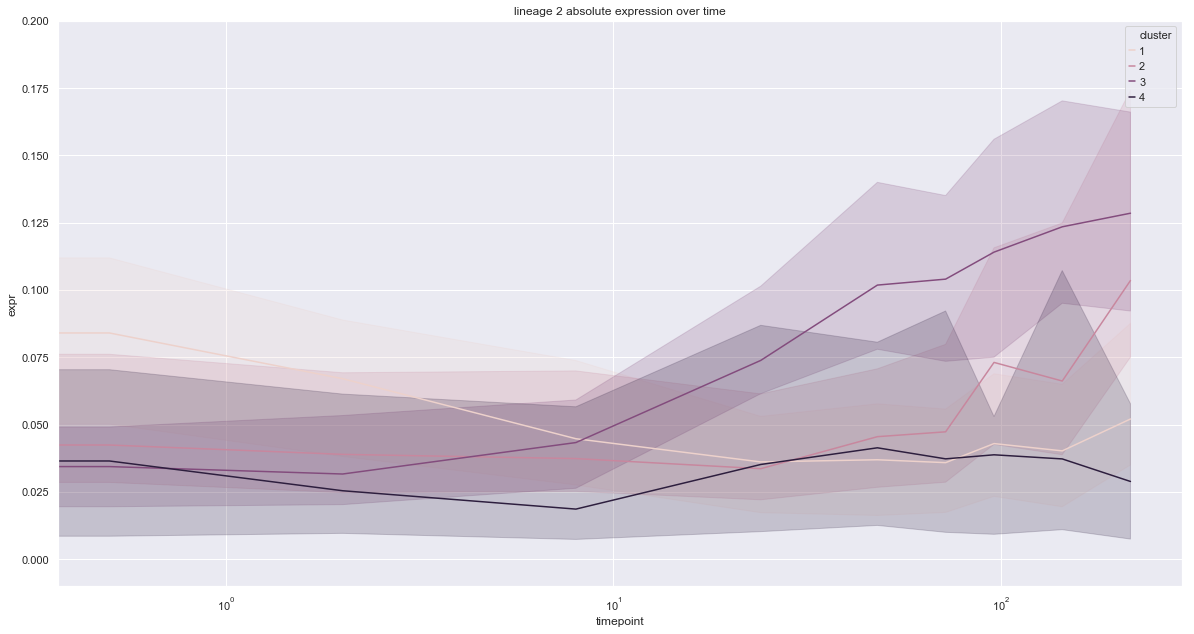

In [679]:
i = 0
###### PLOTTING
for metacells_expr in sets_metacells_expr:
    #### gene expression over time by cluster; expr values
    expr_mean_clust = metacells_expr.copy()
    expr_mean_clust = expr_mean_clust.set_index('cluster')
    ## stack
    expr_mean_clust = pd.DataFrame(expr_mean_clust.stack()).reset_index()
    expr_mean_clust.columns = ['cluster','timepoint','expr']
    expr_mean_clust['timepoint'] = expr_mean_clust['timepoint'].astype(np.float)
    ### lineplot
    seaborn.set(rc={'figure.figsize':(20,10)})
    plt.figure()
    #### plot
    grid = seaborn.lineplot(data=expr_mean_clust,x='timepoint',y='expr',hue='cluster',estimator=np.median)
    grid.set(xscale="log")
    plt.ylim(-0.01,0.2)
    plt.title('lineage '+str(i)+' absolute expression over time')
    ### save
    plt.savefig('figures/YAP_subset_bytime.absolute.lineage_'+str(i)+'.pdf')
    i+=1

### calculate fitness at each timepoint to use as response variable in linear model

In [723]:
sets_metacells_all = []
sets_metacells_expr_all = []
sets_counts = []
##
for tmp_osi in sets_sc:
    ### get metacells, zscore (for plotting) and expr for downstream analysis
    metacells = sceasy.metacell_bylabel(tmp_osi,label='time',zscore=True).transpose()
    metacells_expr = sceasy.metacell_bylabel(tmp_osi,label='time',zscore=False).transpose()
    ### 
    metacells.columns = metacells.columns.astype(str)
    metacells_expr.columns = metacells_expr.columns.astype(str)
    ### format
    metacells = metacells[['0.0','0.5','2.0','8.0','24.0','48.0','72.0','96.0','144.0','216.0']]
    metacells_expr = metacells_expr[['0.0','0.5','2.0','8.0','24.0','48.0','72.0','96.0','144.0','216.0']]
    ### count cells
    tmpcounts = tmp_osi.obs.time.value_counts()
    ### save
    sets_metacells_all.append(metacells)
    sets_metacells_expr_all.append(metacells_expr)
    sets_counts.append(tmpcounts)

In [738]:
ratios = pd.concat(sets_counts,axis=1)
ratios = ratios.transpose()/ratios.transpose().sum()
ratios = ratios.transpose()/ratios[0.0]
ratios.columns = ['lin0','lin1','lin2']
ratios = ratios.stack().reset_index()
ratios.columns = ['time','lineage','proportion']

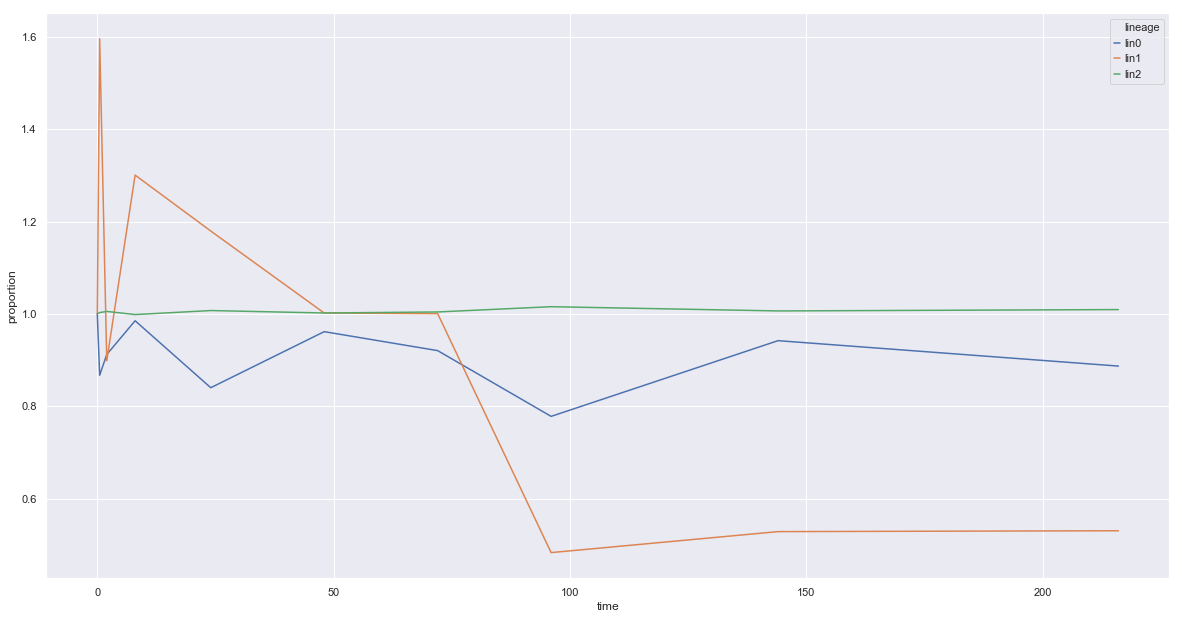

In [740]:
seaborn.lineplot(data=ratios,x='time',y='proportion',hue='lineage')


## as expected, these are quite messy

## diff exp for pre and post 8 hours

In [13]:
###readin
osi= sceasy.read('../osi_only.preprocessed')
### change things over into continuous time
sample_dict = {
    '0T':0,
    'OSI_T1_30m':0.5,
    'OSI_T2_2H':2,
    'OSI_T3_8H':8,
    'OSI_T4_24H':24,
    'OSI_T5_48H':48,
    'OSI_T6_3D':72,
    'OSI_T7_4D':96,
    'OSI_T8_6D':144,
    'OSI_T9_9D':216,
}
###
osi.obs['time'] = osi.obs.apply(lambda row: sample_dict[row['sample']],axis=1) 

In [4]:
# ### create dict
# lineage_dict = {}
# i=0
# for tmp_set in sets_sc:
#     indices = tmp_set.obs.index.tolist()
#     for index in indices:
#         lineage_dict[index] = i 
#     i+=1
# ### assign to master sc object
# osi.obs['lineage'] = osi.obs.apply(lambda row: lineage_dict[row.name],axis=1)

In [73]:
def isin(sample,keep):
    if sample in keep:
        return('True')
    else:
        return('False')
####
keep = [8.0,24.0]
subset = osi[osi.obs.time.isin(keep)]
subset.obs['post8'] = subset.obs.apply(lambda row: isin(row['time'],keep=[24.0]),axis=1)
### make full data matrix to do manual ttest
df = pd.DataFrame(subset.X,columns=subset.var.index,index=subset.obs.index)
df['post8'] = subset.obs['post8']
pre = df[df.post8=='False'].drop('post8',axis=1)
post = df[df.post8=='True'].drop('post8',axis=1)

Trying to set attribute `.obs` of view, making a copy.


In [74]:
from scipy.stats import ttest_ind
###
ttest_results = []
for gene in pre.columns:
    tmp = -np.log10(ttest_ind(pre[gene],post[gene])[1])
    ttest_results.append(tmp)

/avicenna/Johnny/envs/scanpy2/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


In [75]:
logfc_results = np.log2(pre.mean()/post.mean())

In [91]:
scores = pd.Series(ttest_results)
names = pd.Series(pre.columns.tolist())
logfc = pd.Series(logfc_results.tolist())
###
merged_diff = pd.concat([scores,names,logfc],axis=1)
###
merged_diff.columns = ['score','gene','logfc']
###
merged_diff.replace([np.inf,-np.inf],np.nan,inplace=True)
merged_diff.dropna(inplace=True)

In [105]:
merged_diff.to_csv('figures/volcano.t8_vs_t24.csv')

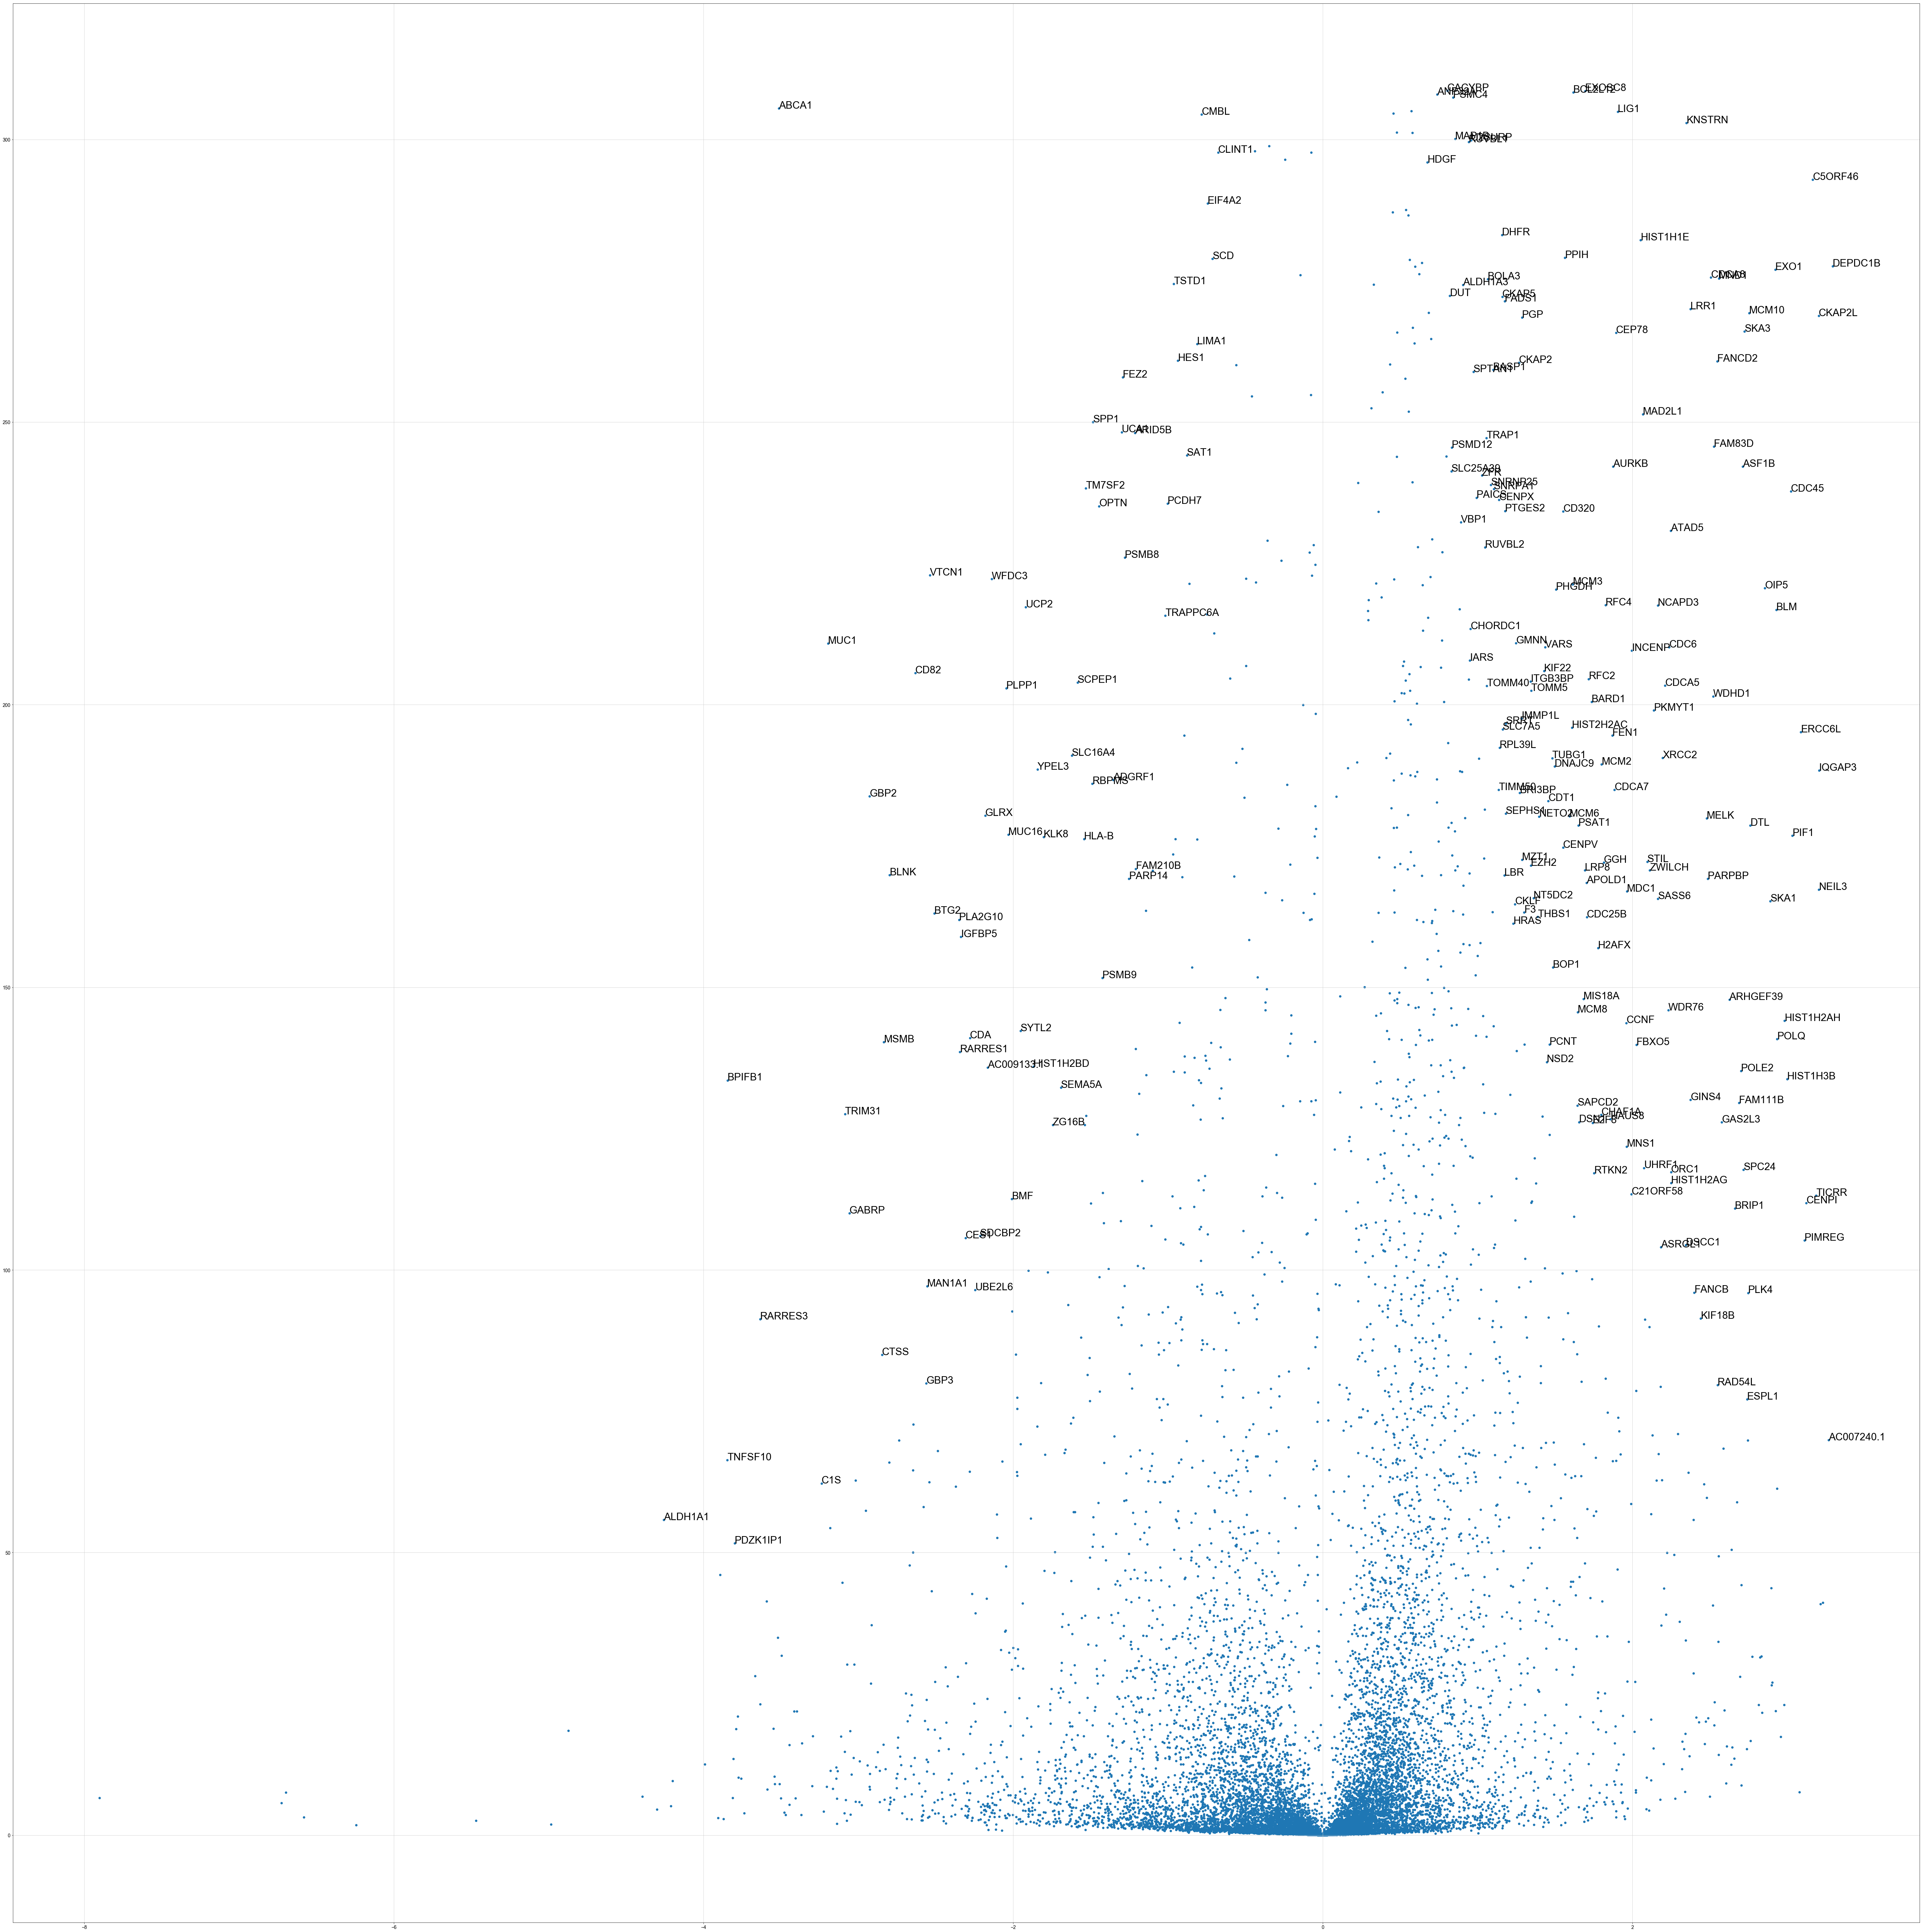

In [106]:
import scipy.stats.mstats as mstats
###
fig = plt.figure(figsize=(100,100))
##
y = list(merged_diff['score'])
x = list(merged_diff['logfc'])
geom_cutoff = 14
###
plt.scatter(x,y)
###
for i, txt in enumerate(merged_diff.gene.tolist()):
    if mstats.gmean([abs(x[i]),abs(y[i])]) > geom_cutoff:
        plt.annotate(txt, (x[i], y[i]),size=30)
###
plt.savefig('figures/volcano.t8_vs_t24.bigtext.pdf')

#### sanity check

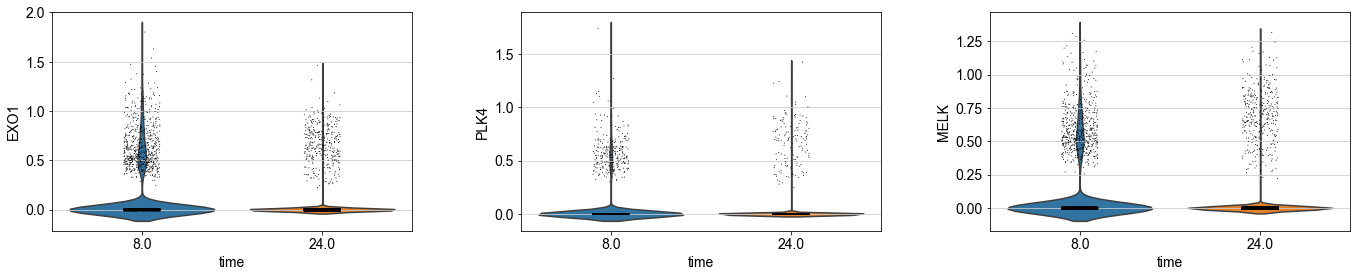

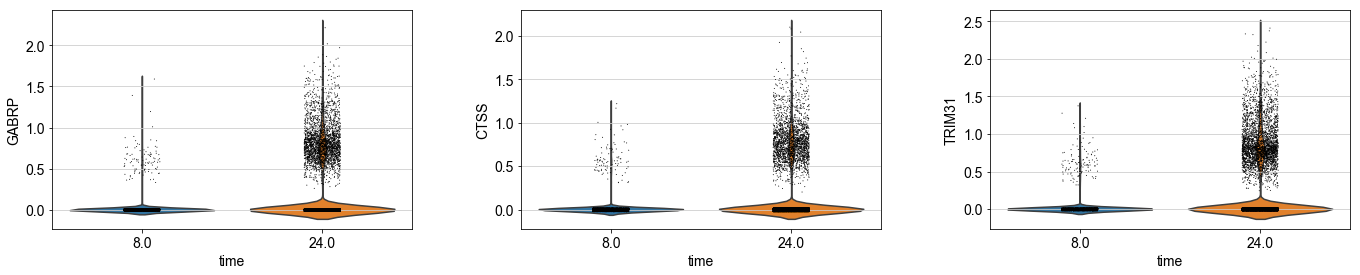

In [107]:
sc.pl.violin(subset,keys=['EXO1','PLK4','MELK'],groupby='time',save='8_hi.pdf')
sc.pl.violin(subset,keys=['GABRP','CTSS','TRIM31'],groupby='time',save='8_lo.pdf')

In [118]:
### make ipage FC file
pd.DataFrame(merged_diff.set_index('gene')['logfc']).to_csv('log2FC_8v24.tsv',sep='\t')

## ipage

In [110]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import scipy.stats
###generate databases to loop through
cmd = "ls -d /nvme/bins/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/human_ensembl*"
### save as list for looping
databases = os.popen(cmd).read().split('\n')
##format
tmp = []
for db in databases:
    tmp.append(db.split('/')[-1])
databases = tmp.copy()
databases = list(filter(None,databases))

In [111]:
%%bash 

cp /nvme/bins/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/human_ensembl_msigdb_c6/human_ensembl_msigdb_c6_index.txt human_ensembl_index.txt
awk -F '\t' '{print $1}' human_ensembl_index.txt > ensembl_index.txt

In [120]:
####define index file to loop through
FCfilename = 'log2FC_8v24.tsv'
subpath = 'ipage_outs/'
####
os.system('mkdir '+subpath)
FCfile = pd.read_csv(FCfilename,sep='\t',index_col=0,header=None)
FCfile.columns = ['log10fc']
####get list of ENSG gene names
ENSG = list(set(pd.read_csv('ensembl_index.txt',index_col=0).index.tolist()))
####convert gene names to ENSG
##read in dict
ENSGdict = pd.read_csv('ENSG_geneID.dict',sep='\t',index_col=1).to_dict()['Gene stable ID']
##define dict function
def switch_names(lookup,dictionary):
    if lookup in dictionary:
        return dictionary[lookup]
    else:
        return np.nan
##convert to ENSG
FCfile.index = FCfile.apply(lambda row: switch_names(row.name,ENSGdict),axis=1)
##drop nans
FCfile = FCfile.loc[FCfile.index!=np.nan]
FCfile = FCfile.dropna()
##format columns
FCfile.columns = ['log2FoldChange']
FCfile.index.names = ['Gene']
##save formatted DF, one for each database
savefile = []
for i in range(len(databases)):
    ###make subfolder
    cmd = 'mkdir '+subpath+databases[i]
    os.system(cmd)
    ###save a copy of the FC file to subfolder
    tmpfile = subpath+databases[i]+'/'+FCfilename
    FCfile.to_csv(tmpfile,sep='\t',header=True)
    savefile.append(tmpfile)
print(FCfile.shape)

(13969, 1)


In [121]:
##get cwd
cwd = os.getcwd()+"/"
###write final iPAGE command to an ipage .sh file
for i in range(len(databases)):
    iPAGE_cmd = "perl /nvme/bins/iPAGEv1.0/page.pl --expfile "+ \
                cwd+savefile[i]+" --species="+databases[i]+ \
                " --exptype=continuous --ebins=9 \n"
    os.system(iPAGE_cmd)



In [131]:
#### sanity check
e2f1dp2 = pd.read_csv('E2F1DP2.txt',header=None)[0].tolist()
cdpcr3 = pd.read_csv('cdpcr3.txt',header=None)[0].tolist()
irfq6 = pd.read_csv('irfq6.txt',header=None)[0].tolist()
gataq6 = pd.read_csv('gataq6.txt',header=None)[0].tolist()

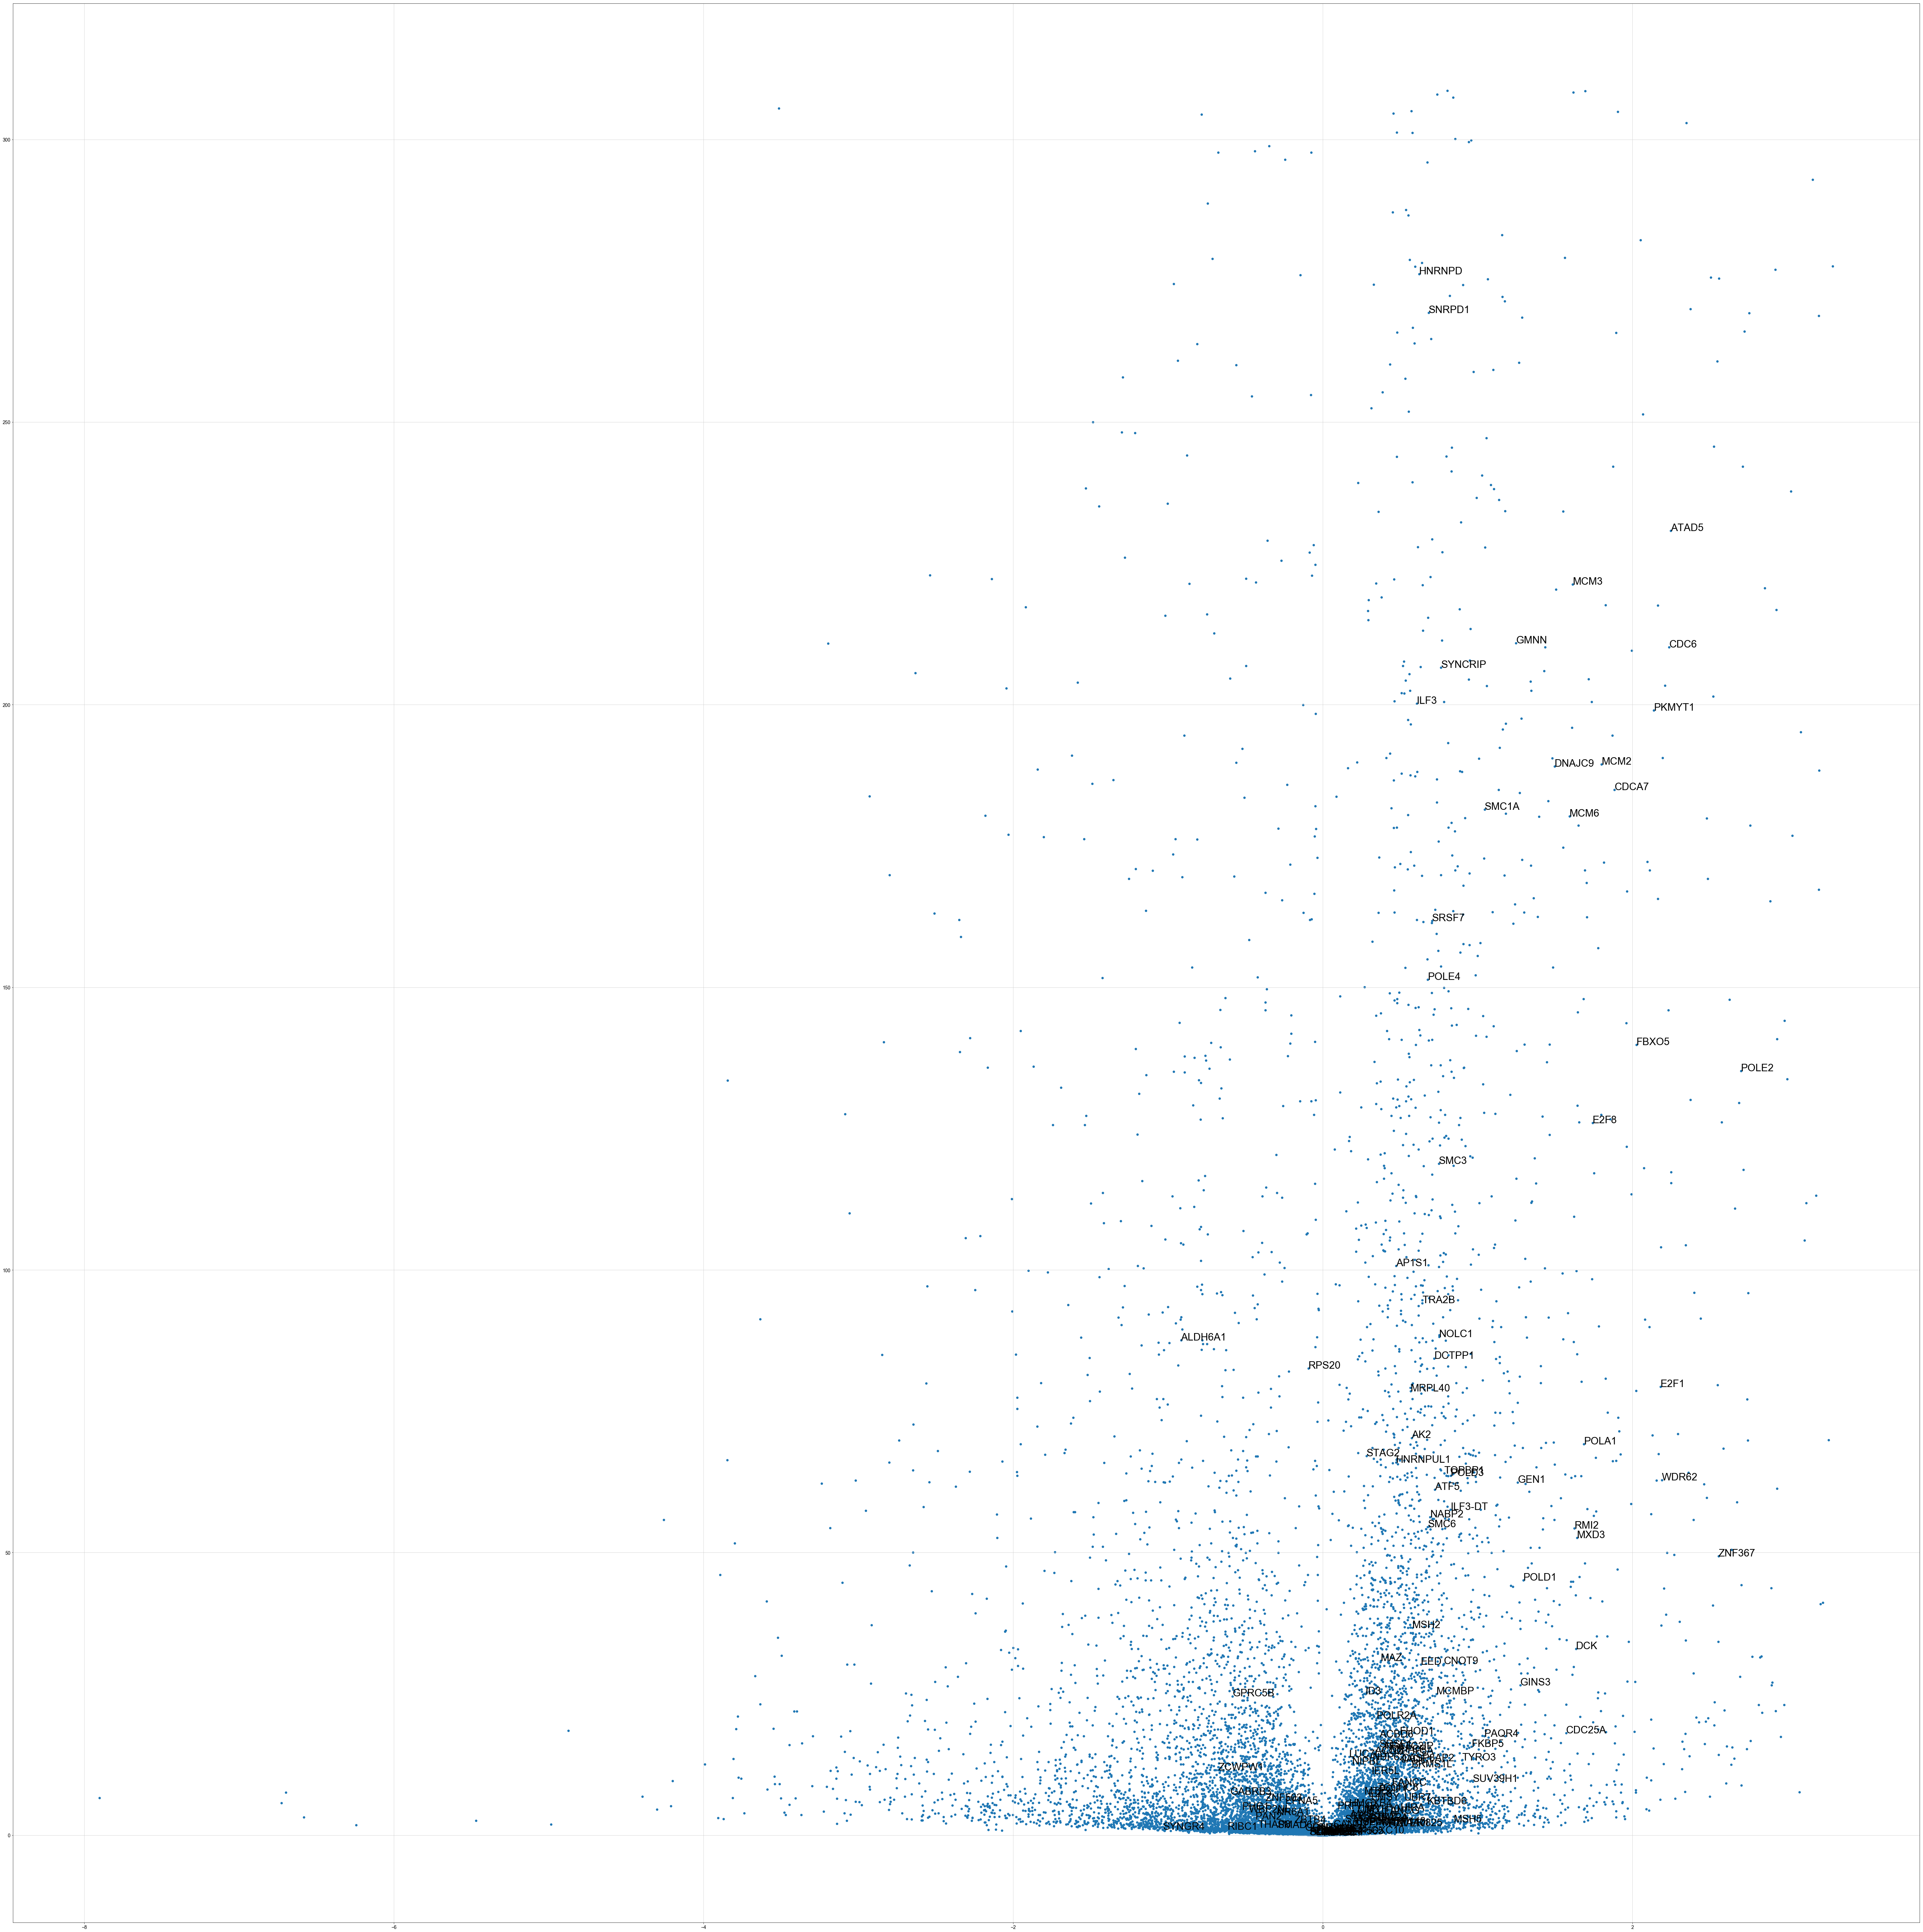

In [129]:
import scipy.stats.mstats as mstats
###
plt.figure(figsize=(100,100))
##
y = list(merged_diff['score'])
x = list(merged_diff['logfc'])
###
plt.scatter(x,y)
###
for i, txt in enumerate(merged_diff.gene.tolist()):
    if txt in e2f1dp2:
        plt.annotate(txt, (x[i], y[i]),size=30)
###
plt.savefig('figures/volcano.t8_vs_t24.bigtext.e2f1dp2.sanitycheck.pdf')

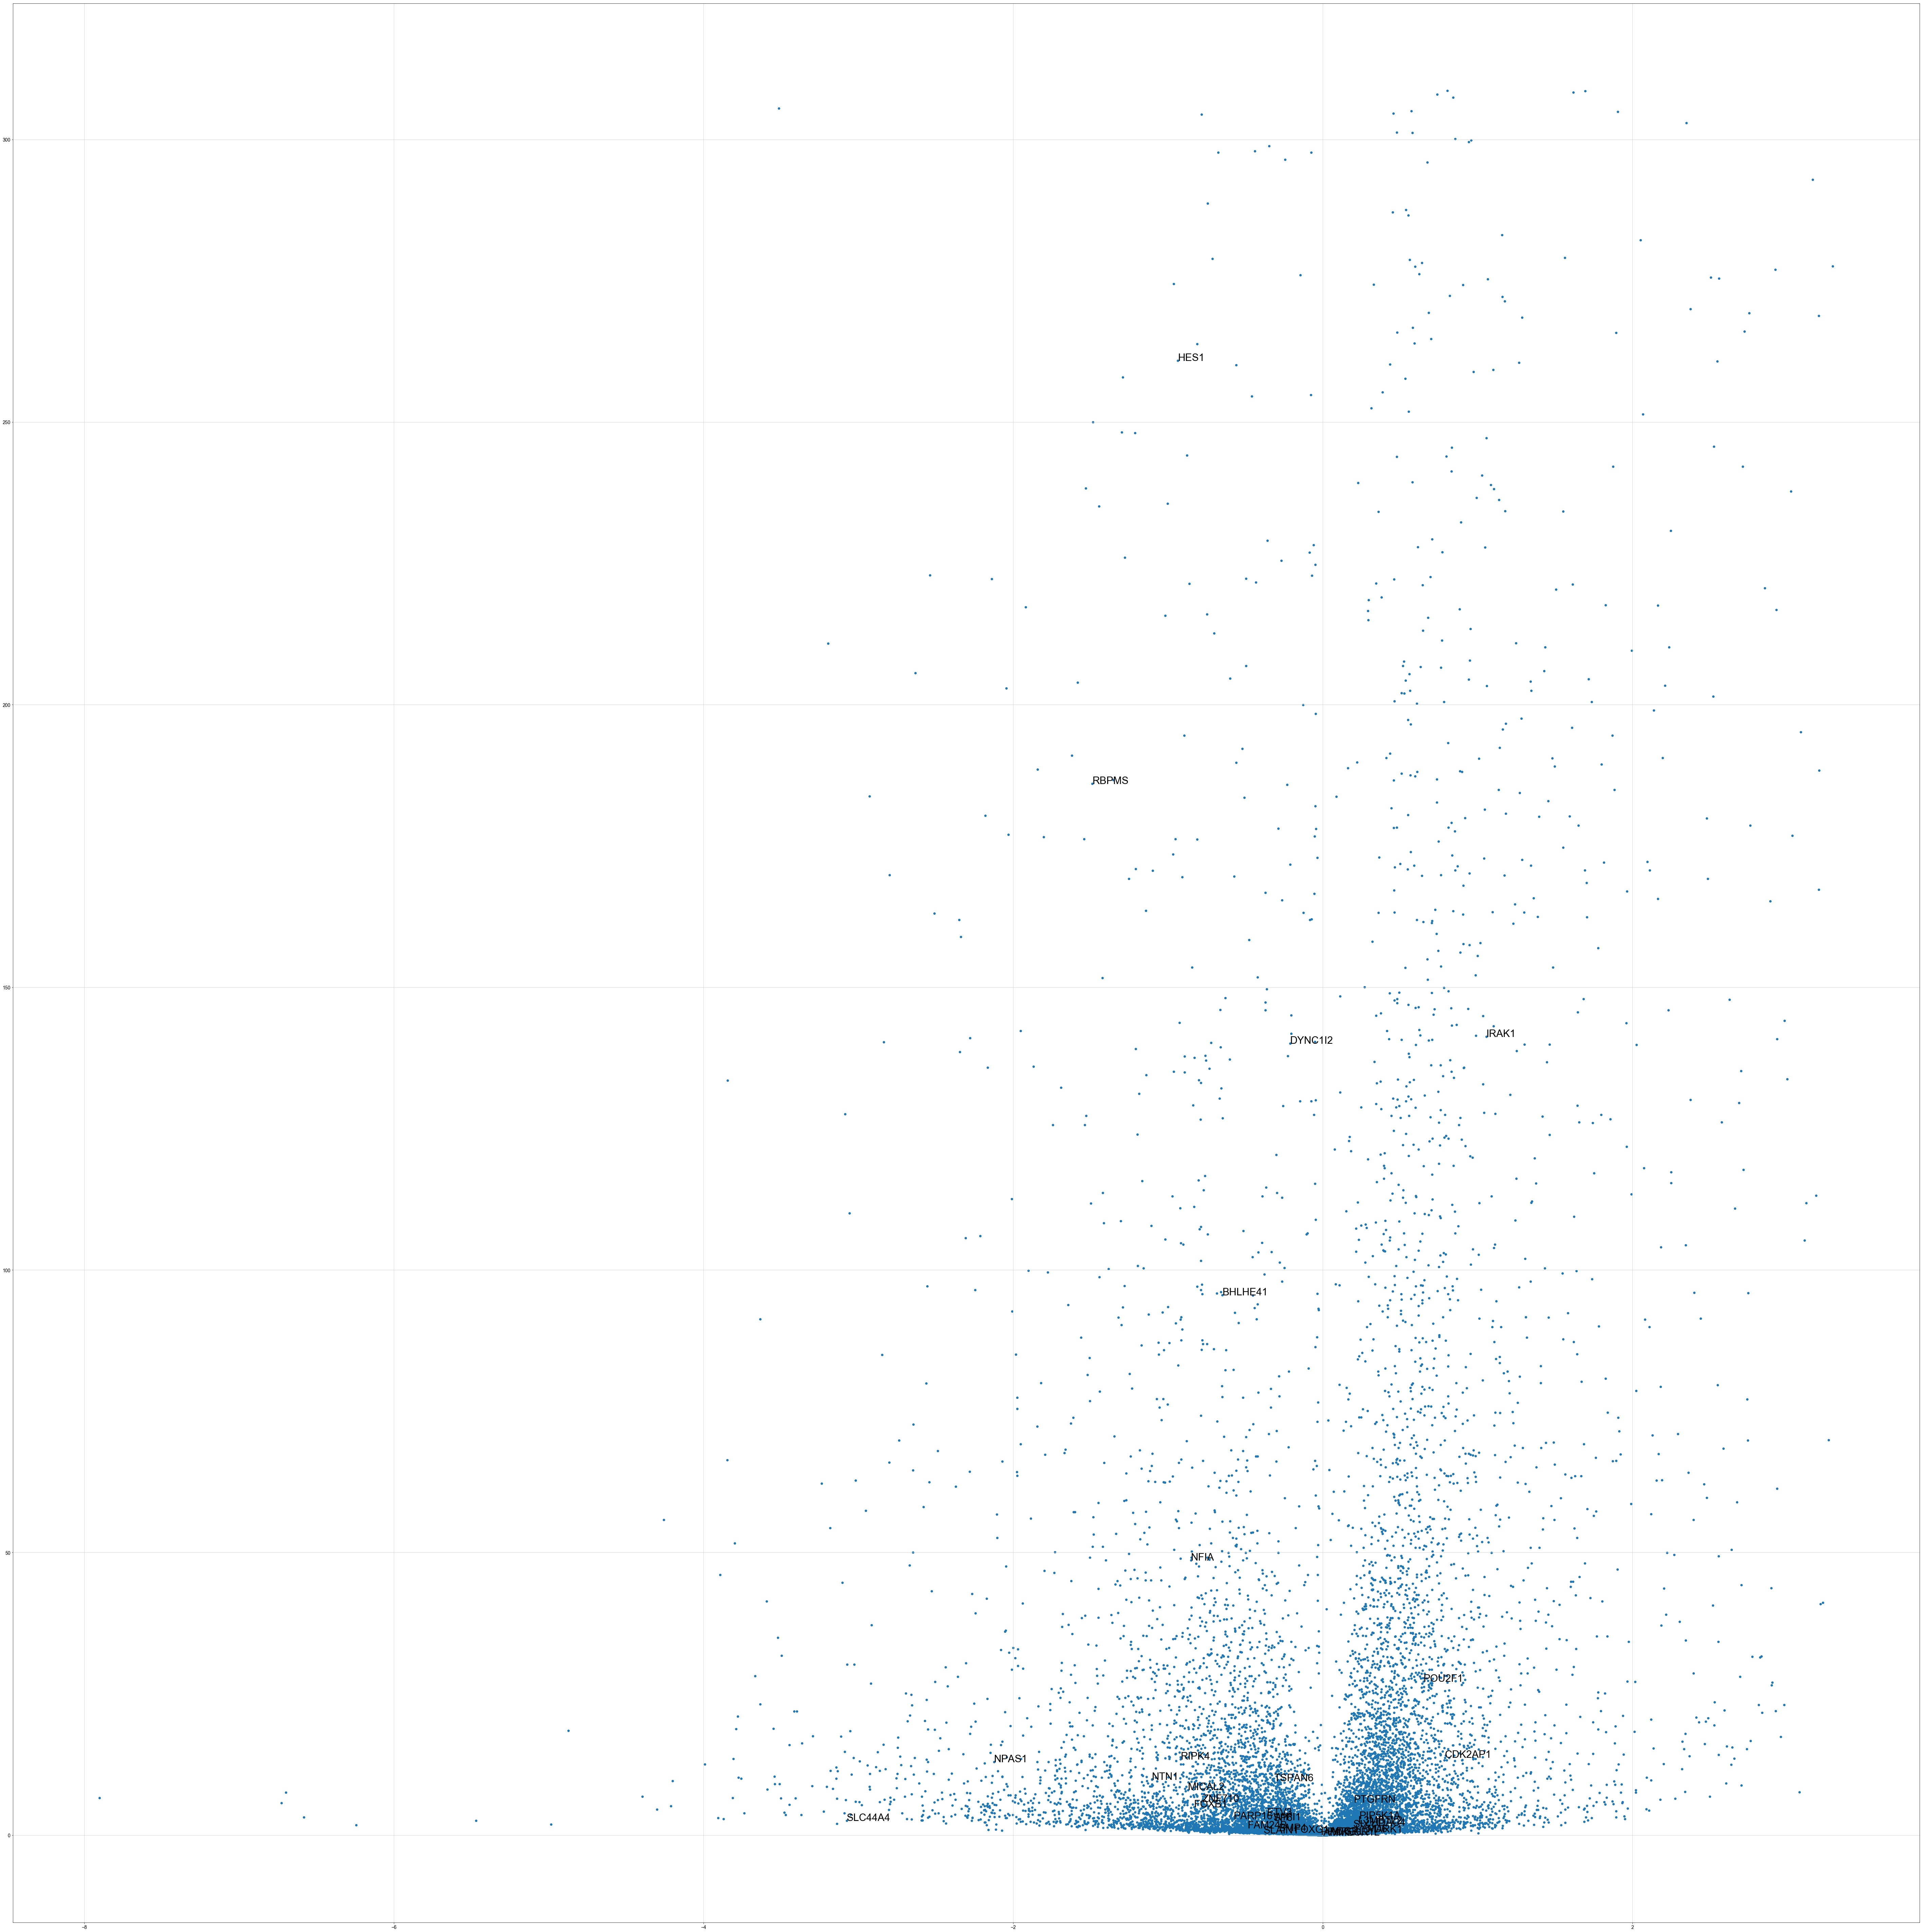

In [132]:
import scipy.stats.mstats as mstats
###
plt.figure(figsize=(100,100))
##
y = list(merged_diff['score'])
x = list(merged_diff['logfc'])
###
plt.scatter(x,y)
###
for i, txt in enumerate(merged_diff.gene.tolist()):
    if txt in cdpcr3:
        plt.annotate(txt, (x[i], y[i]),size=30)
###
plt.savefig('figures/volcano.t8_vs_t24.bigtext.cdpcr3.sanitycheck.pdf')

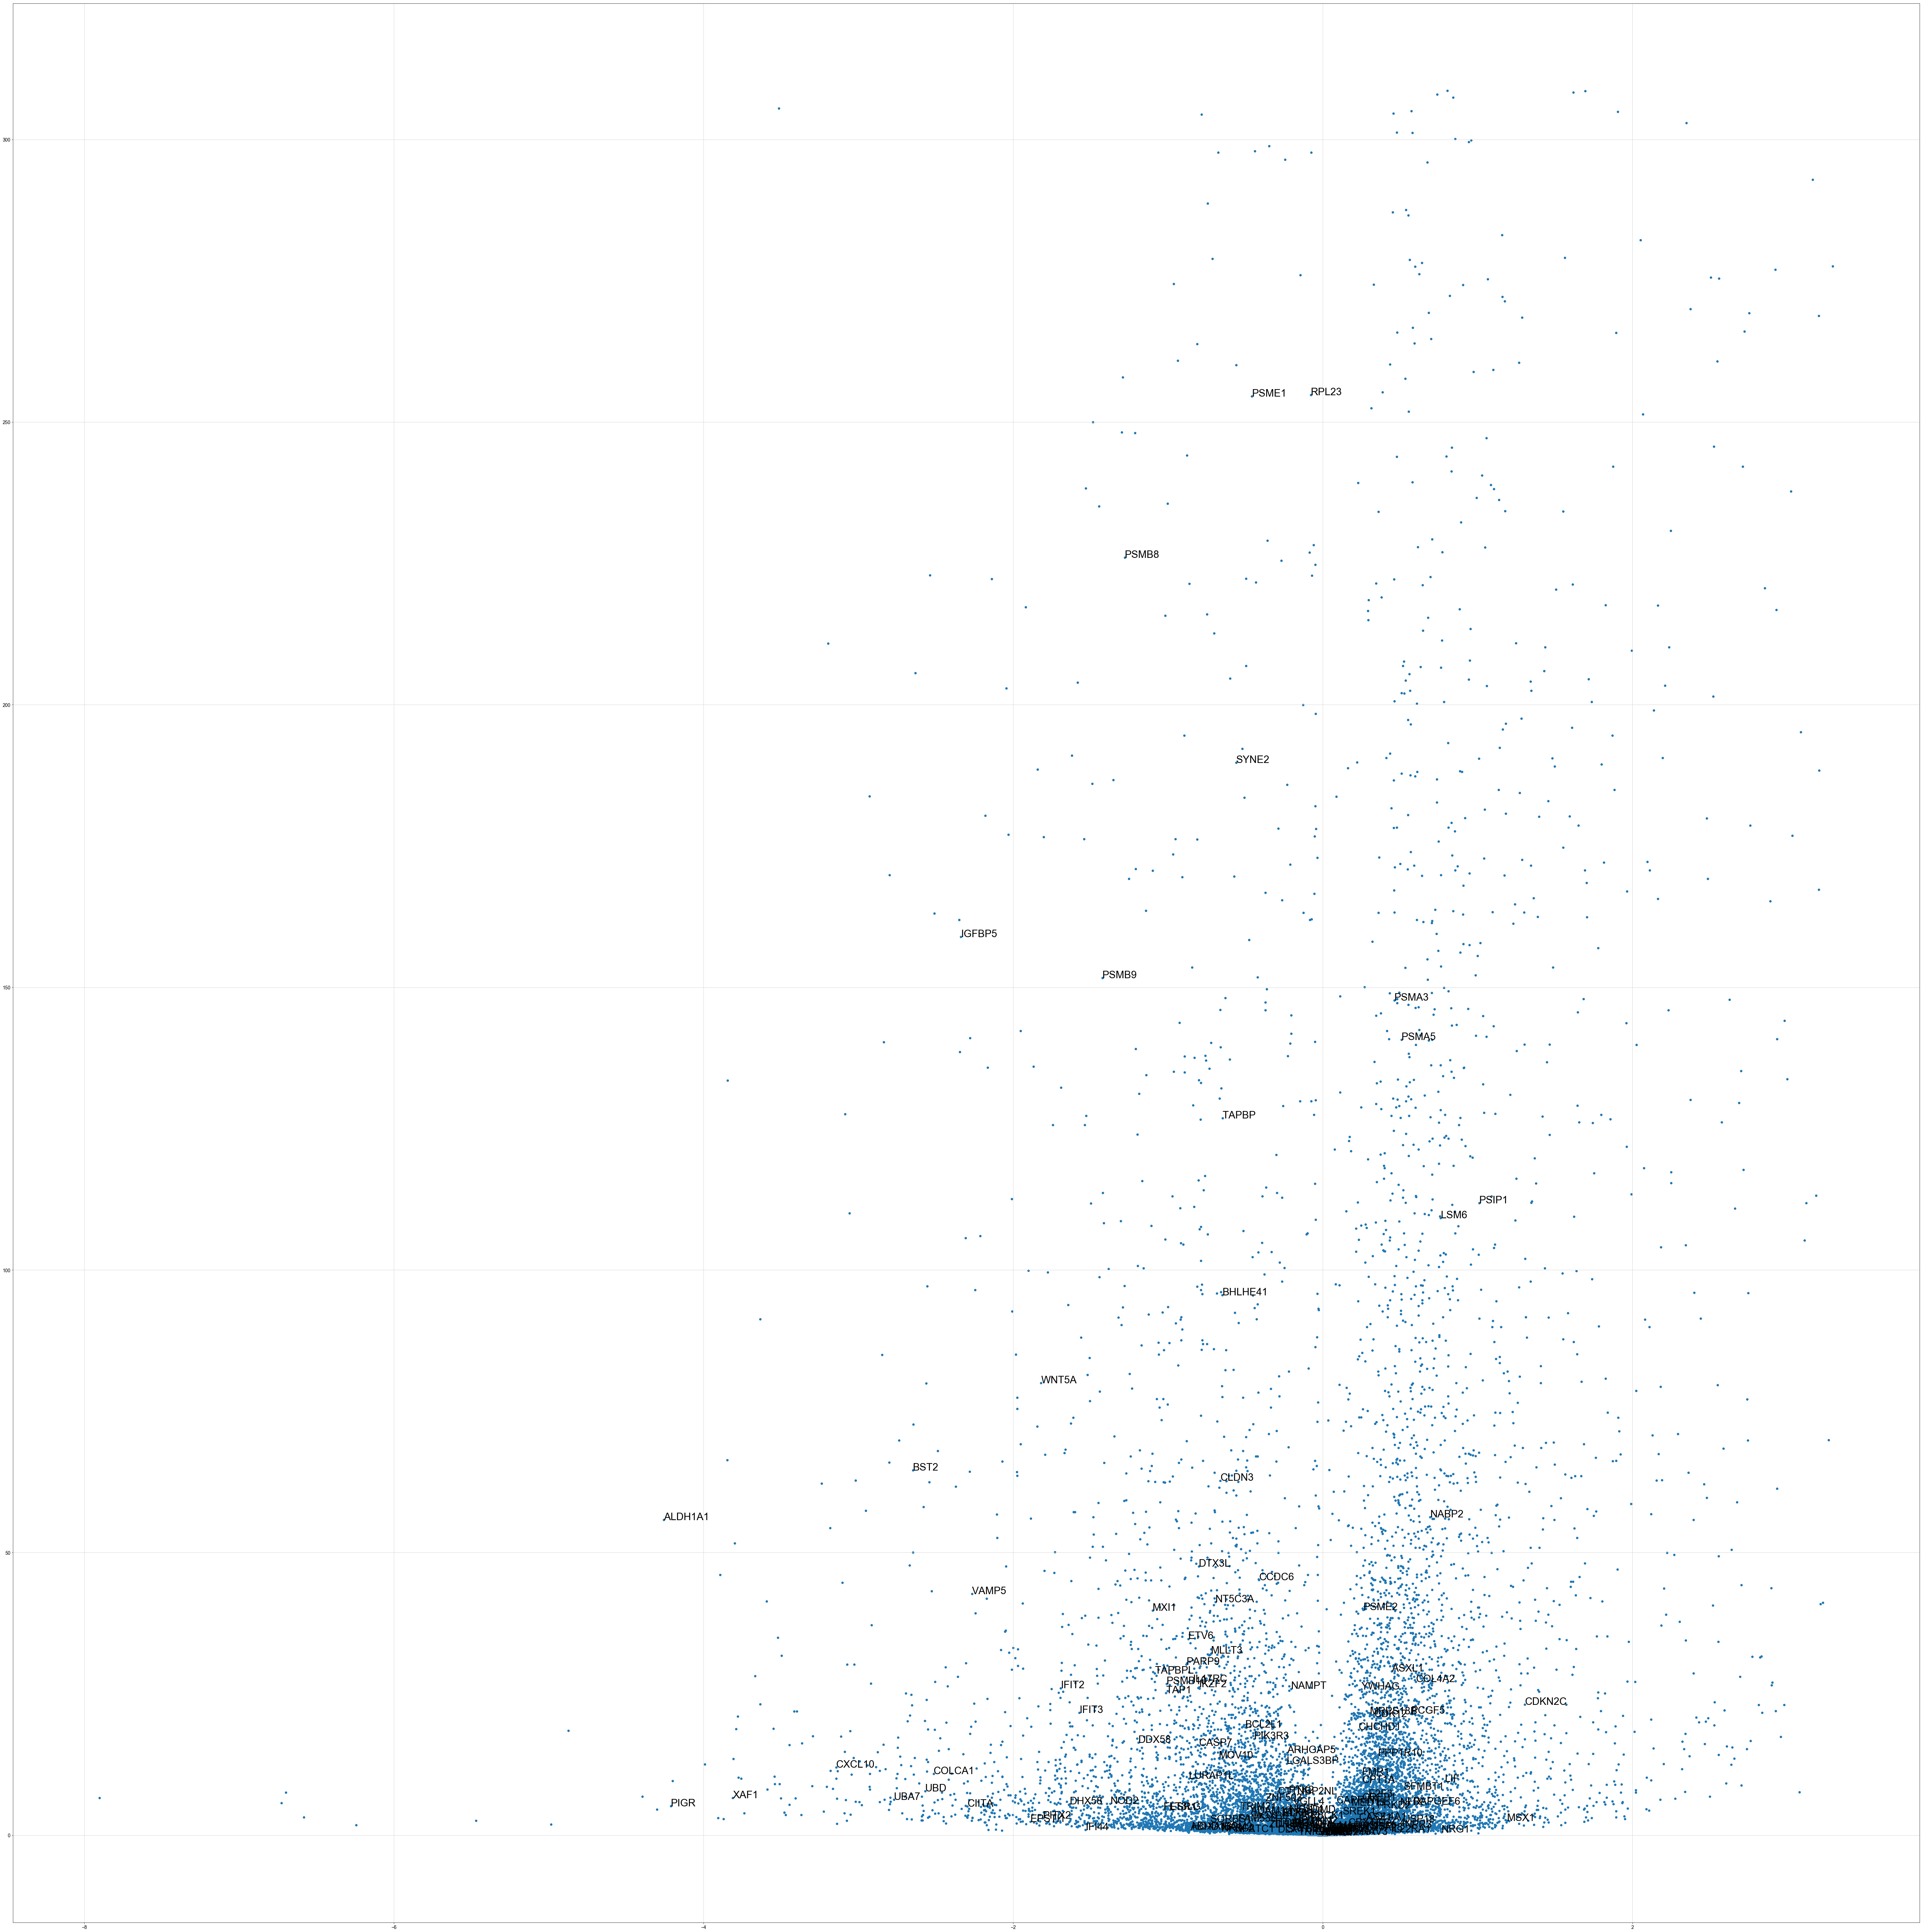

In [133]:
import scipy.stats.mstats as mstats
###
plt.figure(figsize=(100,100))
##
y = list(merged_diff['score'])
x = list(merged_diff['logfc'])
###
plt.scatter(x,y)
###
for i, txt in enumerate(merged_diff.gene.tolist()):
    if txt in irfq6:
        plt.annotate(txt, (x[i], y[i]),size=30)
###
plt.savefig('figures/volcano.t8_vs_t24.bigtext.irfq6.sanitycheck.pdf')

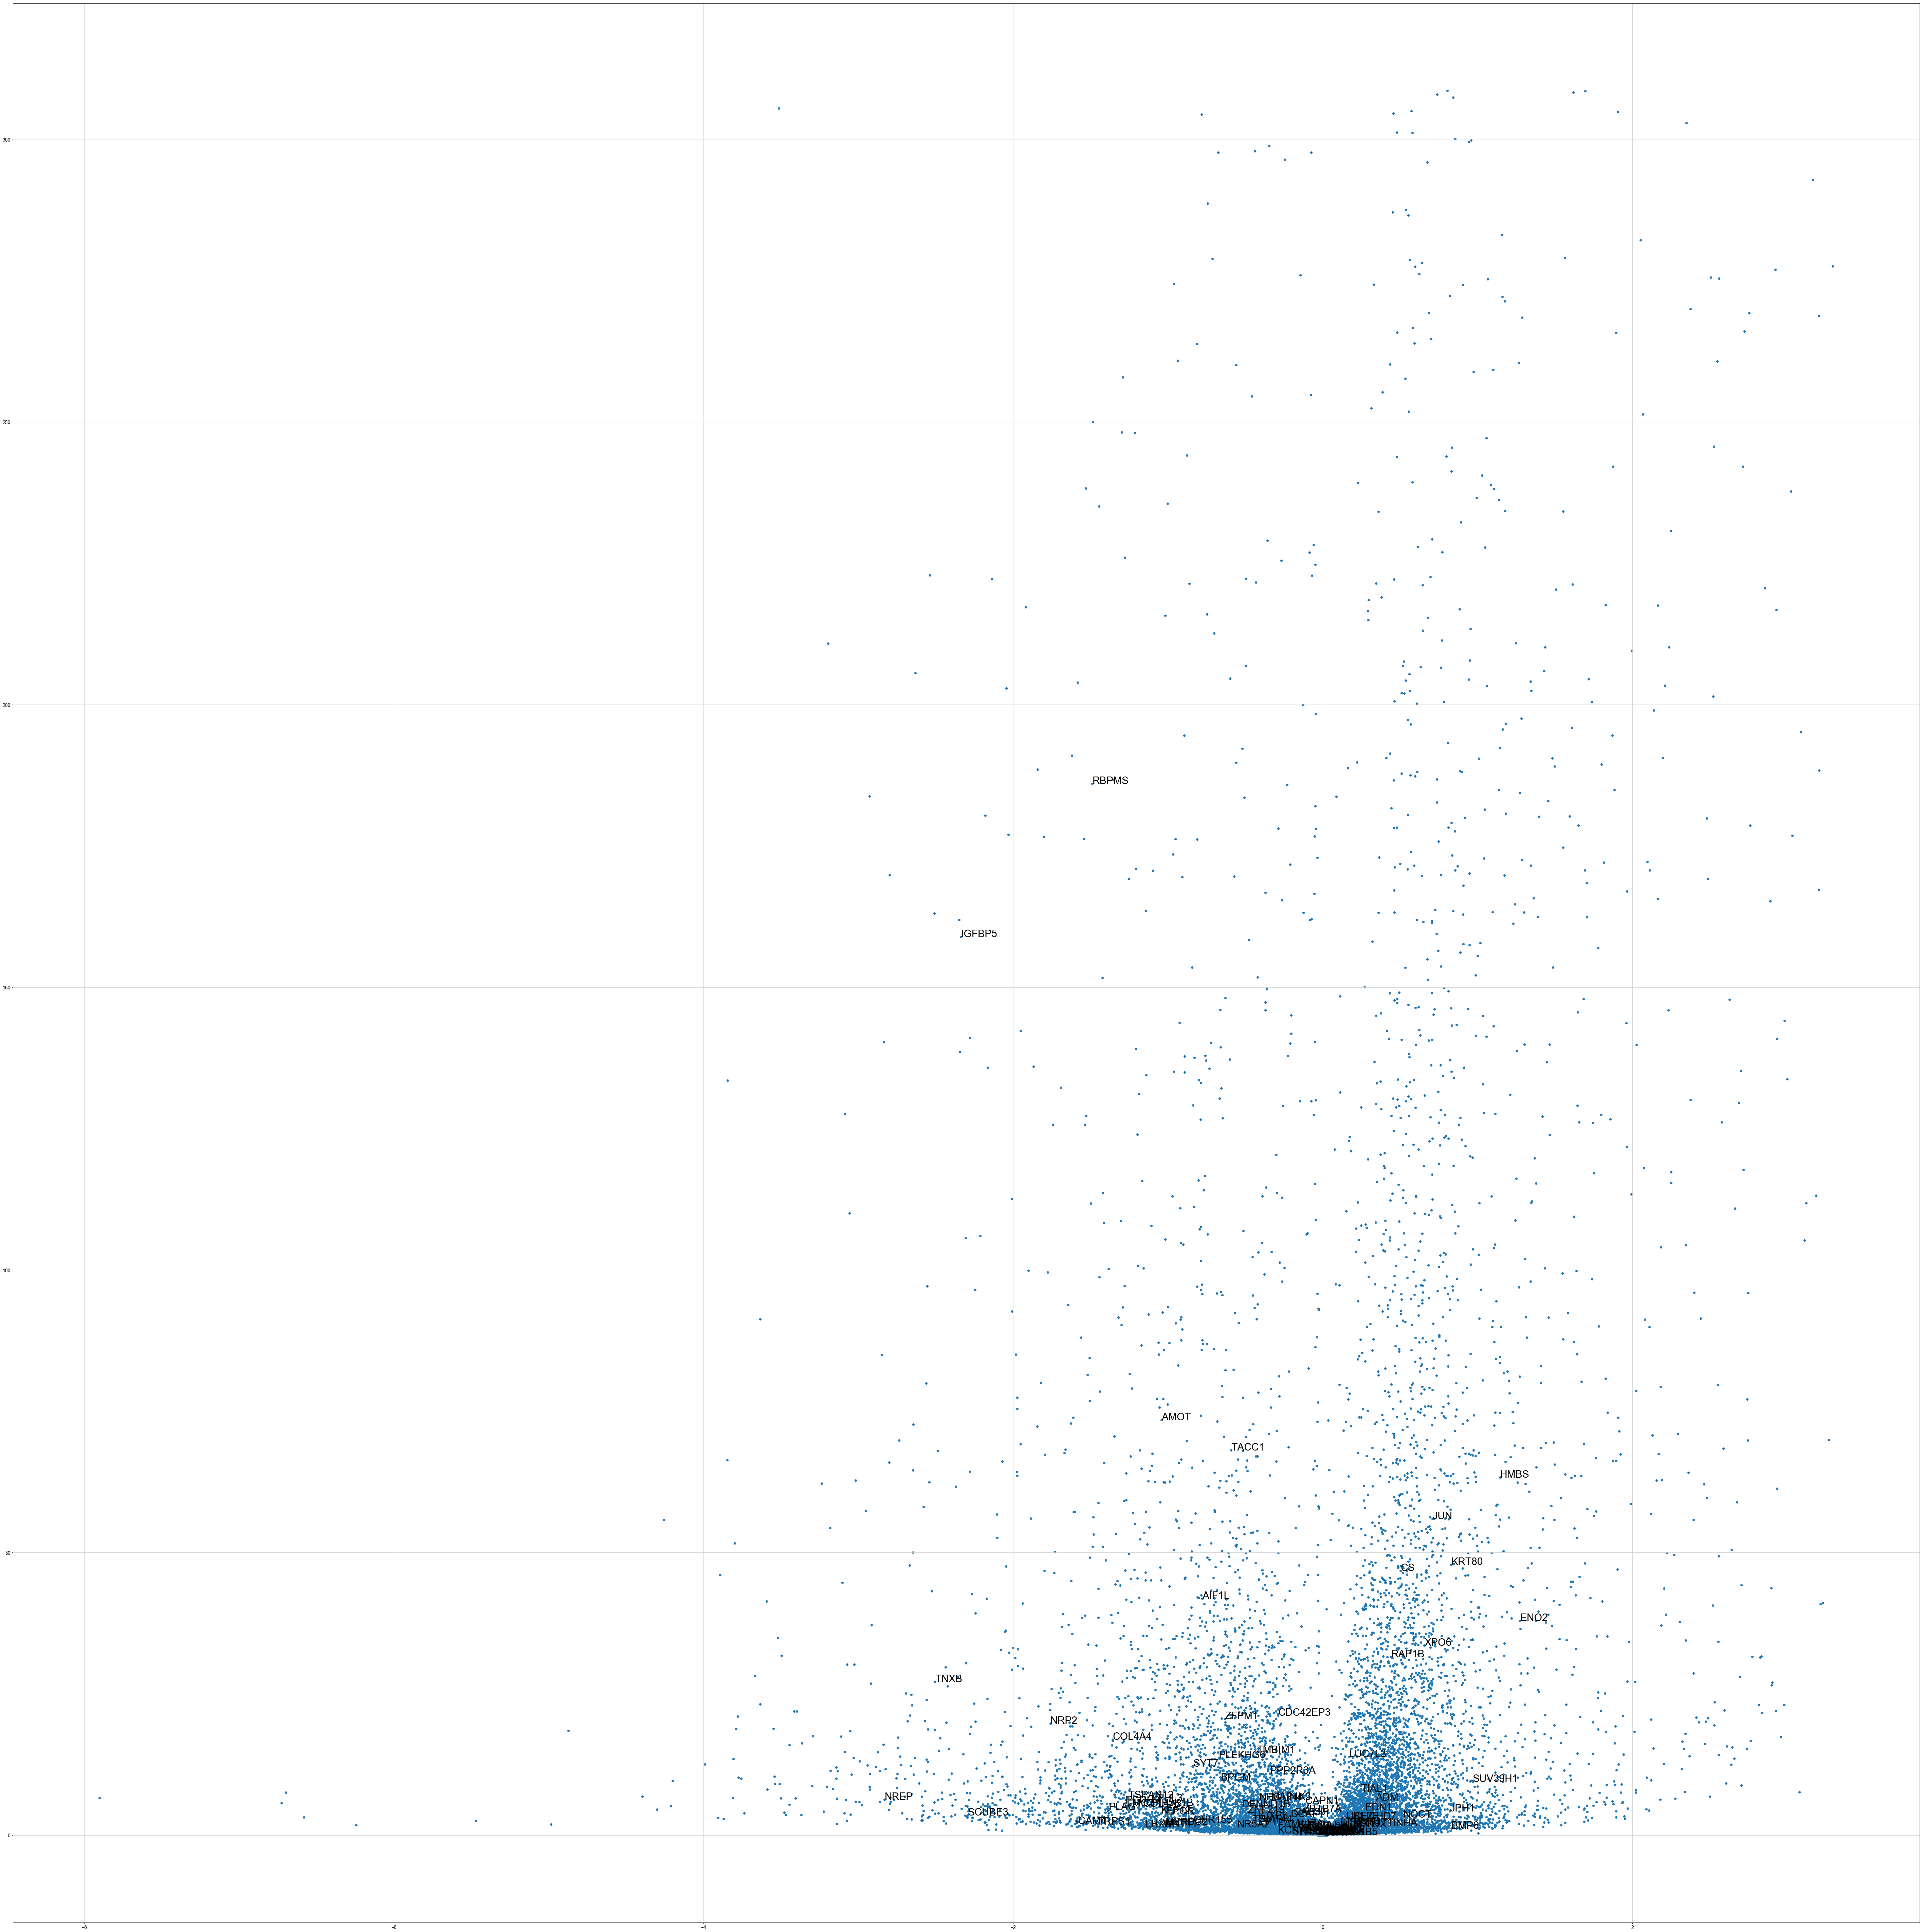

In [134]:
import scipy.stats.mstats as mstats
###
plt.figure(figsize=(100,100))
##
y = list(merged_diff['score'])
x = list(merged_diff['logfc'])
###
plt.scatter(x,y)
###
for i, txt in enumerate(merged_diff.gene.tolist()):
    if txt in gataq6:
        plt.annotate(txt, (x[i], y[i]),size=30)
###
plt.savefig('figures/volcano.t8_vs_t24.bigtext.gataq6.sanitycheck.pdf')